# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera## This notebook will be mainly used for the capstone project

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)


## Introduction: Business Problem <a name="introduction"></a>

In a diverse and huge city like Toronto, it might be intimidating to figure out which neighbourhoods are best in one’s quest to buy a new home, considering the exorbitant prices of homes in certain neighbourhoods. Not only that, one needs to look into different factors like population density, low crime rates, access to parks and playgrounds, and restaurants and cafes while looking at the budget in mind. Here the neighbourhood of Forest Hill South is taken as a reference by the customer due to its high scores in various factors like low crime rate, access to restaurants etc. The only downside is that the homes in Forest Hill South are well above the customer’s budget which is  CAD 800,000. The average price of homes in Forest Hill South in 2017 was CAD 1.329 million (as shown in www.moneysense.ca). 

There are well over 120 neighbourhoods in Toronto. So in order to find the neighbourhoods which are similar to Forest Hill South,  one needs to segment the neighbourhoods based on their low crime rates, the density of population, close proximity to restaurants, cafes, parks etc. The segmentation will be done using clustering technique. After determining which neighbourhoods are similar to Forest Hill South in terms of the features mentioned above, I will be able to find neighbourhoods according to the customers budget and liking.

When a customer visits a real estate agent or a website dealing with real estate, it would be great to have a good idea about the areas to limit the search to. Otherwise,  it will be overwhelming and quite intimidating for the customer to choose from over 120 neighbourhoods. Also, the customer will be interested in neighbourhoods similar to the one they like. The customer would also consider moving to neighbourhoods with low crime rates, population etc even though there are fewer venues like restaurants etc.

## Data <a name="data"></a>

To solve the problem, we need to find the following data:
* List of Neighbourhoods and their properties.
* Latitude and Longitude of the neighbourhoods.
* Venue data of the neighbourhoods.
* Average Prices of homes in each neighbourhood

Sources of data and methods to extract the data.
To find the list of neighbourhoods and their crime rates in order to determine the safety of the neighbourhood, I accessed the website of Toronto Police. They have open data
access to various crimes’ ratings from 2014 to 2018. They had a geojson file(https://opendata.arcgis.com/datasets/af500b5abb7240399853b35a2362d0c0_0.geojson) which helped
in determining the crime according to the neighbourhoods. The following information would be extracted from the dataset: “Neighbourhood”, “Assault_Rate_2018”, “AutoTheft_Rate_2018”, “BreakandEnter_Rate_2018”, Robbery_Rate 2018”, “Homicide_Rate_2018”, “Population”, “Size_of_hood_area”. The Population Density would be calculated by dividing “Population” with “Size_of_hood_area”.The crime rates were calculated according to the population i.e. per capita. 

They were 140 neighbourhoods in the geojson file. Since the coordinates were of boundaries, the centre coordinates of each neighbourhood have to be calculated according 
to the average of all latitudes and longitudes. This would be needed in order to plot the neighbourhood clusters.

To find the venue data, Foursquare API was used. It would show the most popular venues in each neighbourhood of Toronto while using 
the central coordinates of the respective neighbourhood.  

After Segmenting the data, it would be combined with the average home prices of each neighbourhood. The data will be obtained from the blog post from the following link
https://www.moneysense.ca/spend/real-estate/where-to-buy-2019-toronto/. There are some neighbourhoods which are missing from the dataset, and the missing 
prices will be replaced with the mean price of homes across all neighbourhoods.


In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)
import json
!conda install -c conda-forge geopy --yes # To install geopy
from geopy.geocoders import Nominatim
import requests # to handle requests
from pandas.io.json import json_normalize # transform json file into pandas dataframe
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
!conda install -c conda-forge folium=0.5.0 --yes
import folium
print("Libraries Imported")



Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    geopy-1.21.0               |             py_0          58 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0         conda-forge
    geopy:           1.21.0-py_0       conda-forge

The following packages will be UPDATED:

    ca-

In [2]:
# Using !wget to download it from IBM Object Storage and saving the geojson file 
!wget -O af500b5abb7240399853b35a2362d0c0_0.geojson https://opendata.arcgis.com/datasets/af500b5abb7240399853b35a2362d0c0_0.geojson   
print("Hello Capstone Project Course!")

--2020-02-13 09:55:58--  https://opendata.arcgis.com/datasets/af500b5abb7240399853b35a2362d0c0_0.geojson
Resolving opendata.arcgis.com (opendata.arcgis.com)... 34.192.93.16, 34.232.21.248
Connecting to opendata.arcgis.com (opendata.arcgis.com)|34.192.93.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/json]
Saving to: ‘af500b5abb7240399853b35a2362d0c0_0.geojson’

    [ <=>                                   ] 1,794,893   9.20MB/s   in 0.2s   

2020-02-13 09:55:59 (9.20 MB/s) - ‘af500b5abb7240399853b35a2362d0c0_0.geojson’ saved [1794893]

Hello Capstone Project Course!


### Data containing crime, population density and boundary coordinates were obtained from the Toronto Police Open Data Portel

http://data.torontopolice.on.ca/datasets/neighbourhood-crime-rates-boundary-file-

#### Reading the geojson file

In [3]:
with open('af500b5abb7240399853b35a2362d0c0_0.geojson') as json_data:
    Toronto_Crime_Json = json.load(json_data)

In [4]:
Toronto_Crime_Json

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'properties': {'OBJECTID': 1,
    'Neighbourhood_Crime_Rates_Neigh': 'Yonge-St.Clair',
    'Neighbourhood_Crime_Rates_Hood_': '097',
    'Hood_ID': 97,
    'Neighbourhood': 'Yonge-St.Clair',
    'Assault_2014': 58,
    'Assault_2015': 38,
    'Assault_2016': 51,
    'Assault_2017': 46,
    'Assault_2018': 61,
    'Assault_AVG': 50.8,
    'Assault_CHG': '33%',
    'Assault_Rate_2018': 1912.8,
    'Auto_Theft_2014': 28,
    'Auto_Theft_2015': 32,
    'Auto_Theft_2016': 22,
    'Auto_Theft_2017': 46,
    'Auto_Theft_2018': 69,
    'AutoTheft_AVG': 39.4,
    'AutoTheft_CHG': '50%',
    'AutoTheft_Rate_2018': 2163.7,
    'BreakandEnter_2014': 29,
    'BreakandEnter_2015': 16,
    'BreakandEnter_2016': 28,
    'BreakandEnter_2017': 32,
    'BreakandEnter_2018': 23,
    'BreakandEnter_AVG': 25.6,
    'BreakandEnter_CHG': '-28%',
    'BreakandEnter_Rate_2018': 721.2,
    'Robbery_2014': 12,
    'Robbery_2015': 25,
    'Robbery_

In [5]:
Toronto_Crime=Toronto_Crime_Json['features'] 

In [6]:
Toronto_Crime[0]

{'type': 'Feature',
 'properties': {'OBJECTID': 1,
  'Neighbourhood_Crime_Rates_Neigh': 'Yonge-St.Clair',
  'Neighbourhood_Crime_Rates_Hood_': '097',
  'Hood_ID': 97,
  'Neighbourhood': 'Yonge-St.Clair',
  'Assault_2014': 58,
  'Assault_2015': 38,
  'Assault_2016': 51,
  'Assault_2017': 46,
  'Assault_2018': 61,
  'Assault_AVG': 50.8,
  'Assault_CHG': '33%',
  'Assault_Rate_2018': 1912.8,
  'Auto_Theft_2014': 28,
  'Auto_Theft_2015': 32,
  'Auto_Theft_2016': 22,
  'Auto_Theft_2017': 46,
  'Auto_Theft_2018': 69,
  'AutoTheft_AVG': 39.4,
  'AutoTheft_CHG': '50%',
  'AutoTheft_Rate_2018': 2163.7,
  'BreakandEnter_2014': 29,
  'BreakandEnter_2015': 16,
  'BreakandEnter_2016': 28,
  'BreakandEnter_2017': 32,
  'BreakandEnter_2018': 23,
  'BreakandEnter_AVG': 25.6,
  'BreakandEnter_CHG': '-28%',
  'BreakandEnter_Rate_2018': 721.2,
  'Robbery_2014': 12,
  'Robbery_2015': 25,
  'Robbery_2016': 14,
  'Robbery_2017': 21,
  'Robbery_2018': 19,
  'Robbery_AVG': 18.2,
  'Robbery_CHG': '-10%',
  'Ro

In [7]:
Column_Names=['Neighbourhood', 'Assault_Rate_2018', 'AutoTheft_Rate_2018', 'BreakandEnter_Rate_2018', 'Robbery_Rate_2018', 'Homicide_Rate_2018', 'Population',
             'Size_of_hood_area', 'Latitude', 'Longitude']

In [8]:
Neighbourhood_Crime=pd.DataFrame(columns=Column_Names)
Neighbourhood_Crime

Empty DataFrame
Columns: [Neighbourhood, Assault_Rate_2018, AutoTheft_Rate_2018, BreakandEnter_Rate_2018, Robbery_Rate_2018, Homicide_Rate_2018, Population, Size_of_hood_area, Latitude, Longitude]
Index: []

### Extracting the column details from the json file and input into converting boundary data into point of central coordinates  for each neighborhood

In [9]:
for data in Toronto_Crime:
    Neighbourhood=data['properties']['Neighbourhood']
    Assault=data['properties']['Assault_Rate_2018']
    Auto_Theft=data['properties']['AutoTheft_Rate_2018']
    BreakandEnter=data['properties']['BreakandEnter_Rate_2018']
    Robbery=data['properties']['Robbery_Rate_2018']
    Homicide=data['properties']['Homicide_Rate_2018']
    Population=data['properties']['Population']
    Area=data['properties']['Shape__Area']
    Lats=[]
    Lons=[]
    Neighbourhood_LatLon_Boundary=data['geometry']['coordinates']
    for item in Neighbourhood_LatLon_Boundary[0]:
        Lats.append(item[1])
        Lons.append(item[0])
    Neighbourhood_Lat=np.array(Lats).mean()
    Neighbourhood_Lon=np.array(Lons).mean()
    Neighbourhood_Crime=Neighbourhood_Crime.append({'Neighbourhood':Neighbourhood,
                                                   'Assault_Rate_2018':Assault,
                                                   'AutoTheft_Rate_2018':Auto_Theft,
                                                   'BreakandEnter_Rate_2018':BreakandEnter,
                                                   'Robbery_Rate_2018':Robbery,
                                                   'Homicide_Rate_2018':Homicide,
                                                   'Population':Population,
                                                   'Size_of_hood_area':Area,
                                                   'Latitude':Neighbourhood_Lat,
                                                   'Longitude':Neighbourhood_Lon}, ignore_index=True)
    

In [10]:
Neighbourhood_Crime[0:10]

Neighbourhood  Assault_Rate_2018  AutoTheft_Rate_2018  \
0                Yonge-St.Clair             1912.8               2163.7   
1       York University Heights              375.4                 62.6   
2              Lansing-Westgate             1923.5                214.8   
3            Yorkdale-Glen Park              696.5                153.6   
4           Stonegate-Queensway              576.4                184.6   
5        Tam O'Shanter-Sullivan              128.2                105.3   
6                   The Beaches             1610.4                 77.5   
7  Thistletown-Beaumond Heights              187.0                155.9   
8              Thorncliffe Park             1616.4               1364.9   
9            Danforth East York             2165.0               1487.8   

   BreakandEnter_Rate_2018  Robbery_Rate_2018 Homicide_Rate_2018 Population  \
0                    721.2              595.8                  0       3189   
1                    141.4               40.8                2.7      36764   
2                    507.7              400.3                  0      10242   
3                    307.1              192.0                 11      18233   
4                    184.6              162.1                  0      22207   
5                     41.2               25.2                2.3      43695   
6                    831.6              274.9                  0      28378   
7                    155.9               49.9               12.5      16039   
8                    718.4              502.9                  0       8352   
9                   1096.8              314.7                  0      10485   

   Size_of_hood_area   Latitude  Longitude  
0       1.161315e+06  43.688762 -79.399013  
1       1.324666e+07  43.759661 -79.499115  
2       5.346186e+06  43.753880 -79.422502  
3       6.038326e+06  43.717458 -79.452711  
4       7.946202e+06  43.636838 -79.496012  
5       5.422345e+06  43.779365 -79.306608  
6       3.595829e+06  43.668305 -79.294287  
7       3.339481e+06  43.737721 -79.558346  
8       3.126554e+06  43.707124 -79.348242  
9       2.188598e+06  43.689215 -79.331051

### Map of Toronto using Folium

In [11]:
Latitude=43.697786
Longitude=-79.362862
Toronto_Crime_Map=folium.Map(location=[Latitude, Longitude], zoom_start=11)
Toronto_Crime_Map

## Methodology <a name="methodology"></a>

If we see the size of neighbourhoods, it varies. Therefore we need to convert the population into population density so that we can use it for clustering of the data. However, the population data needs to be retained, so we can convert crime rates into per capita crime rates. 

### Plotting Neighborhoods with size of circle representing population of the neighborhood

In [12]:
from folium.features import DivIcon
from folium import IFrame

In [13]:
Toronto_Hood_Map=folium.Map(location=[Latitude, Longitude], zoom_start=11)
#adding markers to the map
for lat, lon, neighbourhood, population in zip(Neighbourhood_Crime['Latitude'], Neighbourhood_Crime['Longitude'], 
                                              Neighbourhood_Crime['Neighbourhood'],Neighbourhood_Crime['Population']):
    label='{}'.format(neighbourhood)
    label=folium.Popup(parse_html=True)
    folium.CircleMarker([lat,lon], radius=np.sqrt(population/300),
                       popup=label, color='green', fill=True, fill_color='green', fill_opacity=0.7,
                       parse_thml=False).add_to(Toronto_Hood_Map)
folium.map.Marker([(43.694286-.09), (-79.412848+.08)], icon = DivIcon(icon_size=(1000,100), icon_anchor=(0,0), 
                   html='<div style="font_size: 12pt">Circle Area = Population of Neighbourhood </div>',
                                                                   )
                 ).add_to(Toronto_Hood_Map)
text='Forest Hill South'
iframe=folium.IFrame(text, width=20, height=15)
popup=folium.Popup(iframe, max_width=3000)
Text=folium.Marker(location=[43.694286, -79.412848], popup=popup, icon=folium.Icon(icon_color='blue'))
Toronto_Hood_Map.add_child(Text)
Toronto_Hood_Map

In [14]:
Neighbourhood_Crime.columns

Index(['Neighbourhood', 'Assault_Rate_2018', 'AutoTheft_Rate_2018',
       'BreakandEnter_Rate_2018', 'Robbery_Rate_2018', 'Homicide_Rate_2018',
       'Population', 'Size_of_hood_area', 'Latitude', 'Longitude'],
      dtype='object')

#### Creating a 'per capita' variables for each crime 

In [15]:
Neighbourhood_Crime['Assault_per_Capita']=Neighbourhood_Crime['Assault_Rate_2018']/Neighbourhood_Crime['Population']
Neighbourhood_Crime['AutoTheft_per_Capita']=Neighbourhood_Crime['AutoTheft_Rate_2018']/Neighbourhood_Crime['Population']
Neighbourhood_Crime['BreakandEnter_per_Capita']=Neighbourhood_Crime['BreakandEnter_Rate_2018']/Neighbourhood_Crime['Population']
Neighbourhood_Crime['Robbery_per_Capita']=Neighbourhood_Crime['Robbery_Rate_2018']/Neighbourhood_Crime['Population']
Neighbourhood_Crime['Homicide_per_Capita']=Neighbourhood_Crime['Homicide_Rate_2018']/Neighbourhood_Crime['Population']
Neighbourhood_Crime

Neighbourhood  Assault_Rate_2018  \
0                         Yonge-St.Clair             1912.8   
1                York University Heights              375.4   
2                       Lansing-Westgate             1923.5   
3                     Yorkdale-Glen Park              696.5   
4                    Stonegate-Queensway              576.4   
5                 Tam O'Shanter-Sullivan              128.2   
6                            The Beaches             1610.4   
7           Thistletown-Beaumond Heights              187.0   
8                       Thorncliffe Park             1616.4   
9                     Danforth East York             2165.0   
10                    Humewood-Cedarvale             1995.7   
11            Islington-City Centre West              419.7   
12                              Danforth              113.4   
13                                Rustic             1448.5   
14                   Scarborough Village             2334.2   
15                        South Parkdale              305.1   
16                       South Riverdale               53.0   
17                  St.Andrew-Windfields              451.1   
18                         Taylor-Massey              626.0   
19                         Humber Summit              246.7   
20                            Humbermede              862.5   
21                Centennial Scarborough             3521.8   
22                 Church-Yonge Corridor              145.2   
23                   Clairlea-Birchmount              382.7   
24                            Cliffcrest             3956.8   
25                       Flemingdon Park              218.1   
26                Corso Italia-Davenport              878.7   
27                               Ionview             2599.5   
28                         Junction Area             4227.1   
29                       Broadview North              349.0   
30                    Princess-Rosethorn              582.2   
31                       North Riverdale              534.2   
32                   Etobicoke West Mall             4524.6   
33                     Forest Hill North              628.3   
34                Glenfield-Jane Heights              964.3   
35                     Greenwood-Coxwell              259.4   
36                             Guildwood             1185.8   
37                     Trinity-Bellwoods              394.1   
38                      Victoria Village             1236.7   
39     Waterfront Communities-The Island               82.4   
40                             West Hill              184.2   
41                West Humber-Clairville              240.6   
42                   Westminster-Branson              309.1   
43                          Kennedy Park             2257.9   
44         Kingsview Village-The Westway              761.9   
45                 Bayview Woods-Steeles              670.7   
46                          Clanton Park             1487.2   
47              Keelesdale-Eglinton West             1613.8   
48                     O'Connor-Parkview              195.6   
49                         Old East York              547.6   
50                             Casa Loma              814.4   
51                  Kensington-Chinatown             3339.5   
52                        Kingsway South              985.5   
53          Runnymede-Bloor West Village              207.4   
54                     Forest Hill South             1069.4   
55                            Henry Farm              770.3   
56                                 Annex              281.3   
57                    Caledonia-Fairbank             1114.9   
58              Humber Heights-Westmount              451.7   
59                          Roncesvalles             1215.0   
60                            University             1184.4   
61                     Hillcrest Village              352.3   
62                          Mount Dennis             1345.

### Plotting Neighbourhoods with Robbery per capita as the circle size

In [16]:
Toronto_Hood_Map=folium.Map(location=[Latitude, Longitude], zoom_start=11)
#adding markers to the map
for lat, lon, neighbourhood, robbery in zip(Neighbourhood_Crime['Latitude'], Neighbourhood_Crime['Longitude'], 
                                              Neighbourhood_Crime['Neighbourhood'],Neighbourhood_Crime['Robbery_per_Capita']):
    label='{}'.format(neighbourhood)
    label=folium.Popup(parse_html=True)
    folium.CircleMarker([lat,lon], radius=np.sqrt(robbery*3000),
                       popup=label, color='maroon', fill=True, fill_color='red', fill_opacity=0.7,
                       parse_thml=False).add_to(Toronto_Hood_Map)
folium.map.Marker([(43.694286-.09), (-79.412848+.08)], icon = DivIcon(icon_size=(1000,100), icon_anchor=(0,0), 
                   html='<div style="font_size: 12pt">Circle Area = Robbery per capita </div>',
                                                                   )
                 ).add_to(Toronto_Hood_Map)
text='Forest Hill South'
iframe=folium.IFrame(text, width=20, height=15)
popup=folium.Popup(iframe, max_width=3000)
Text=folium.Marker(location=[43.694286, -79.412848], popup=popup, icon=folium.Icon(icon_color='blue'))
Toronto_Hood_Map.add_child(Text)
Toronto_Hood_Map

### Plotting Neighbourhoods with Assault per capita as the circle size

In [17]:
Toronto_Hood_Map=folium.Map(location=[Latitude, Longitude], zoom_start=11)
#adding markers to the map
for lat, lon, neighbourhood, assault in zip(Neighbourhood_Crime['Latitude'], Neighbourhood_Crime['Longitude'], 
                                              Neighbourhood_Crime['Neighbourhood'],Neighbourhood_Crime['Assault_per_Capita']):
    label='{}'.format(neighbourhood)
    label=folium.Popup(parse_html=True)
    folium.CircleMarker([lat,lon], radius=np.sqrt(assault*500),
                       popup=label, color='maroon', fill=True, fill_color='red', fill_opacity=0.7,
                       parse_thml=False).add_to(Toronto_Hood_Map)
folium.map.Marker([(43.694286-.09), (-79.412848+.08)], icon = DivIcon(icon_size=(1000,100), icon_anchor=(0,0), 
                   html='<div style="font_size: 12pt">Circle Area = Assault per capita of Neighbourhood </div>',
                                                                   )
                 ).add_to(Toronto_Hood_Map)
text='Forest Hill South'
iframe=folium.IFrame(text, width=20, height=15)
popup=folium.Popup(iframe, max_width=3000)
Text=folium.Marker(location=[43.694286, -79.412848], popup=popup, icon=folium.Icon(icon_color='blue'))
Toronto_Hood_Map.add_child(Text)
Toronto_Hood_Map

When we plot the crime rates per capita, for example, “Assault per capita” or “Robbery per capita” as the circle size for a neighbourhood, we can see that the crime rate vary very differently from other neighbourhoods. Same is the case with other crimes.

## Analysis <a name="analysis"></a>

### Cleaning the Dataframe and exploring the dataset

In [18]:
Neighbourhood_Crime.drop(['Assault_Rate_2018', 'AutoTheft_Rate_2018', 'BreakandEnter_Rate_2018', 'Robbery_Rate_2018', 'Homicide_Rate_2018'], axis=1, inplace=True)

In [19]:
Neighbourhood_Crime.head()

Neighbourhood Population  Size_of_hood_area   Latitude  \
0           Yonge-St.Clair       3189       1.161315e+06  43.688762   
1  York University Heights      36764       1.324666e+07  43.759661   
2         Lansing-Westgate      10242       5.346186e+06  43.753880   
3       Yorkdale-Glen Park      18233       6.038326e+06  43.717458   
4      Stonegate-Queensway      22207       7.946202e+06  43.636838   

   Longitude Assault_per_Capita AutoTheft_per_Capita BreakandEnter_per_Capita  \
0 -79.399013           0.599812             0.678489                 0.226152   
1 -79.499115          0.0102111           0.00170275               0.00384615   
2 -79.422502           0.187805            0.0209725                0.0495704   
3 -79.452711             0.0382           0.00842429                0.0168431   
4 -79.496012          0.0259558           0.00831269               0.00831269   

  Robbery_per_Capita Homicide_per_Capita  
0            0.18683                   0  
1         0.00110978         7.34414e-05  
2          0.0390842                   0  
3          0.0105304         0.000603302  
4          0.0072995                   0

In [20]:
Neighbourhood_Crime["Population_Density"]=Neighbourhood_Crime["Population"]/Neighbourhood_Crime["Size_of_hood_area"]*1000
Neighbourhood_Crime.head()

Neighbourhood Population  Size_of_hood_area   Latitude  \
0           Yonge-St.Clair       3189       1.161315e+06  43.688762   
1  York University Heights      36764       1.324666e+07  43.759661   
2         Lansing-Westgate      10242       5.346186e+06  43.753880   
3       Yorkdale-Glen Park      18233       6.038326e+06  43.717458   
4      Stonegate-Queensway      22207       7.946202e+06  43.636838   

   Longitude Assault_per_Capita AutoTheft_per_Capita BreakandEnter_per_Capita  \
0 -79.399013           0.599812             0.678489                 0.226152   
1 -79.499115          0.0102111           0.00170275               0.00384615   
2 -79.422502           0.187805            0.0209725                0.0495704   
3 -79.452711             0.0382           0.00842429                0.0168431   
4 -79.496012          0.0259558           0.00831269               0.00831269   

  Robbery_per_Capita Homicide_per_Capita Population_Density  
0            0.18683                   0            2.74603  
1         0.00110978         7.34414e-05            2.77534  
2          0.0390842                   0            1.91576  
3          0.0105304         0.000603302            3.01955  
4          0.0072995                   0            2.79467

In [21]:
# Calculating pearsons correlation coefficient
from scipy import stats
stats.pearsonr(Neighbourhood_Crime["Population_Density"], Neighbourhood_Crime["Assault_per_Capita"])

(-0.2262069593676606, 0.007200028178117193)

In [22]:
import matplotlib.pyplot as plt
# Building a scatter plot with linear regression line
fit=np.polyfit(Neighbourhood_Crime["Population_Density"].astype(float), Neighbourhood_Crime["Assault_per_Capita"].astype(float), deg=1)
plt.scatter(Neighbourhood_Crime["Population_Density"],Neighbourhood_Crime["Assault_per_Capita"])
plt.plot(Neighbourhood_Crime["Population_Density"], fit[0]*Neighbourhood_Crime["Population_Density"]+fit[1], color="red")
plt.annotate('y={0:.3f}x+{1:.3f}'.format(fit[0], fit[1]),xy=(15,.25))
plt.title("Population Density v Assault per Capita")
plt.xlabel("Population Density")
plt.ylabel("Assault per Capita")

Text(0, 0.5, 'Assault per Capita')

In [23]:
# finding p value
import scipy 
slope, intercept, r_value, p_value, std_error=scipy.stats.linregress(
Neighbourhood_Crime["Population_Density"].astype(float), Neighbourhood_Crime["Assault_per_Capita"].astype(float))
p_value

0.007200028178117155

### Plotting Neighbourhoods with circle size respresenting Population Density

In [24]:
# creating a map of toronto using latitude and longitude
Toronto_Hood_Map=folium.Map(location=[Latitude, Longitude], zoom_start=11)
#adding markers to the map
for lat, lon, neighbourhood, population_density in zip(Neighbourhood_Crime['Latitude'], Neighbourhood_Crime['Longitude'], 
                                              Neighbourhood_Crime['Neighbourhood'],Neighbourhood_Crime['Population_Density']):
    label='{}'.format(neighbourhood)
    label=folium.Popup(parse_html=True)
    folium.CircleMarker([lat,lon], radius=np.sqrt(population_density*10),
                       popup=label, color='black', fill=True, fill_color='grey', fill_opacity=0.7,
                       parse_thml=False).add_to(Toronto_Hood_Map)
folium.map.Marker([(43.694286-.09), (-79.412848+.08)], icon = DivIcon(icon_size=(1000,100), icon_anchor=(0,0), 
                   html='<div style="font_size: 12pt">Circle Area = Population density of Neighbourhood </div>',
                                                                   )
                 ).add_to(Toronto_Hood_Map)
text='Forest Hill South'
iframe=folium.IFrame(text, width=20, height=15)
popup=folium.Popup(iframe, max_width=3000)
Text=folium.Marker(location=[43.694286, -79.412848], popup=popup, icon=folium.Icon(icon_color='blue'))
Toronto_Hood_Map.add_child(Text)
Toronto_Hood_Map
Toronto_Hood_Map

In [25]:
Neighbourhood_Crime.columns

Index(['Neighbourhood', 'Population', 'Size_of_hood_area', 'Latitude',
       'Longitude', 'Assault_per_Capita', 'AutoTheft_per_Capita',
       'BreakandEnter_per_Capita', 'Robbery_per_Capita', 'Homicide_per_Capita',
       'Population_Density'],
      dtype='object')

### Quering Foursquare API for info regarding nearby venues in each neighbourhood

In [26]:
CLIENT_ID='GFWHTGXXRVLI0XDCVZKWO0U2UI35R3RGEFBRFROZPHYKC5H2'
CLIENT_SECRET='ZU4AEP3IRF03PZ4NKPDBJNY3AYCNL1LAMIF0V4EVIEHFKR0U'
LIMIT=100
VERSION='20180605' 
print('Your Credentials:')
print('CLIENT_ID : ' + CLIENT_ID)
print('CLIENT_SECRET : ' +CLIENT_SECRET)

Your Credentials:
CLIENT_ID : GFWHTGXXRVLI0XDCVZKWO0U2UI35R3RGEFBRFROZPHYKC5H2
CLIENT_SECRET : ZU4AEP3IRF03PZ4NKPDBJNY3AYCNL1LAMIF0V4EVIEHFKR0U


In [27]:
def getNearbyVenues(names, latitudes, longitudes, radius=2000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]["groups"][0]["items"]
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


In [28]:
Toronto_Venues = getNearbyVenues(names=Neighbourhood_Crime['Neighbourhood'],
                                   latitudes=Neighbourhood_Crime['Latitude'],
                                   longitudes=Neighbourhood_Crime['Longitude']
                                  )

Yonge-St.Clair
York University Heights
Lansing-Westgate
Yorkdale-Glen Park
Stonegate-Queensway
Tam O'Shanter-Sullivan
The Beaches
Thistletown-Beaumond Heights
Thorncliffe Park
Danforth East York
Humewood-Cedarvale
Islington-City Centre West
Danforth
Rustic
Scarborough Village
South Parkdale
South Riverdale
St.Andrew-Windfields
Taylor-Massey
Humber Summit
Humbermede
Centennial Scarborough
Church-Yonge Corridor
Clairlea-Birchmount
Cliffcrest
Flemingdon Park
Corso Italia-Davenport
Ionview
Junction Area
Broadview North
Princess-Rosethorn
North Riverdale
Etobicoke West Mall
Forest Hill North
Glenfield-Jane Heights
Greenwood-Coxwell
Guildwood
Trinity-Bellwoods
Victoria Village
Waterfront Communities-The Island
West Hill
West Humber-Clairville
Westminster-Branson
Kennedy Park
Kingsview Village-The Westway
Bayview Woods-Steeles
Clanton Park
Keelesdale-Eglinton West
O'Connor-Parkview
Old East York
Casa Loma
Kensington-Chinatown
Kingsway South
Runnymede-Bloor West Village
Forest Hill South
Henry

In [29]:
print(Toronto_Venues.shape)
Toronto_Venues.head()

(10984, 7)


Neighbourhood  Neighbourhood Latitude  Neighbourhood Longitude  \
0  Yonge-St.Clair               43.688762               -79.399013   
1  Yonge-St.Clair               43.688762               -79.399013   
2  Yonge-St.Clair               43.688762               -79.399013   
3  Yonge-St.Clair               43.688762               -79.399013   
4  Yonge-St.Clair               43.688762               -79.399013   

             Venue  Venue Latitude  Venue Longitude      Venue Category  
0  The Bagel House       43.687374       -79.393696          Bagel Shop  
1             LCBO       43.686991       -79.399238        Liquor Store  
2  Cava Restaurant       43.689809       -79.394932    Tapas Restaurant  
3  Capocaccia Café       43.685915       -79.393305  Italian Restaurant  
4        DAVIDsTEA       43.688376       -79.394158            Tea Room

In [30]:
Toronto_Venues.groupby('Neighbourhood').count()

Neighbourhood Latitude  \
Neighbourhood                                                 
Agincourt North                                          59   
Agincourt South-Malvern West                            100   
Alderwood                                               100   
Annex                                                   100   
Banbury-Don Mills                                       100   
Bathurst Manor                                           48   
Bay Street Corridor                                     100   
Bayview Village                                          69   
Bayview Woods-Steeles                                    42   
Bedford Park-Nortown                                     99   
Beechborough-Greenbrook                                  68   
Bendale                                                  51   
Birchcliffe-Cliffside                                    20   
Black Creek                                              61   
Blake-Jones                                             100   
Briar Hill-Belgravia                                     82   
Bridle Path-Sunnybrook-York Mills                        36   
Broadview North                                         100   
Brookhaven-Amesbury                                      58   
Cabbagetown-South St.James Town                         100   
Caledonia-Fairbank                                      100   
Casa Loma                                               100   
Centennial Scarborough                                   23   
Church-Yonge Corridor                                   100   
Clairlea-Birchmount                                      52   
Clanton Park                                             50   
Cliffcrest                                               39   
Corso Italia-Davenport                                  100   
Danforth                                                100   
Danforth East York                                       95   
Don Valley Village                                       97   
Dorset Park                                             100   
Dovercourt-Wallace Emerson-Junction                     100   
Downsview-Roding-CFB                                     58   
Dufferin Grove                                          100   
East End-Danforth                                       100   
Edenbridge-Humber Valley                                 39   
Eglinton East                                            53   
Elms-Old Rexdale                                         55   
Englemount-Lawrence                                     100   
Eringate-Centennial-West Deane                           49   
Etobicoke West Mall                                      63   
Flemingdon Park                                          78   
Forest Hill North                                        78   
Forest Hill South                                       100   
Glenfield-Jane Heights                                   48   
Greenwood-Coxwell                                       100   
Guildwood                                                13   
Henry Farm                                              100   
High Park North                                         100   
High Park-Swansea                                       100   
Highland Creek                                           22   
Hillcrest Village                                        88   
Humber Heights-Westmount                                 40   
Humber Summit                                            19   
Humbermede                                               41   
Humewood-Cedarvale                                      100   
Ionview                                                 100   
Islington-City Centre West                              100   
Junction Area                                           100   
Keelesdale-Eglinton West                                100   
Kennedy Park                                             55   
Kensi

In [31]:
print('There are {} unique categories'.format(len(Toronto_Venues['Venue Category'].unique())))

There are 334 unique categories


### One hot encoding of venue category data

In [32]:
Toronto_OneHot=pd.get_dummies(Toronto_Venues[['Venue Category']], prefix="", prefix_sep="")
# Adding Neighbourhood column back into the dataframe
Toronto_OneHot['Neighbourhood']=Toronto_Venues['Neighbourhood']
# Moving Neighbourhood column into the first column
fixed_columns=['Neighbourhood']+list(Toronto_OneHot.columns.difference(['Neighbourhood']))
Toronto_OneHot=Toronto_OneHot[fixed_columns]
Toronto_OneHot.head()

Neighbourhood  ATM  Accessories Store  Afghan Restaurant  \
0  Yonge-St.Clair    0                  0                  0   
1  Yonge-St.Clair    0                  0                  0   
2  Yonge-St.Clair    0                  0                  0   
3  Yonge-St.Clair    0                  0                  0   
4  Yonge-St.Clair    0                  0                  0   

   African Restaurant  Airport  Airport Lounge  American Restaurant  \
0                   0        0               0                    0   
1                   0        0               0                    0   
2                   0        0               0                    0   
3                   0        0               0                    0   
4                   0        0               0                    0   

   Amphitheater  Antique Shop  Aquarium  Arcade  Argentinian Restaurant  \
0             0             0         0       0                       0   
1             0             0         0       0                       0   
2             0             0         0       0                       0   
3             0             0         0       0                       0   
4             0             0         0       0                       0   

   Art Gallery  Arts & Crafts Store  Asian Restaurant  Athletics & Sports  \
0            0                    0                 0                   0   
1            0                    0                 0                   0   
2            0                    0                 0                   0   
3            0                    0                 0                   0   
4            0                    0                 0                   0   

   Auto Dealership  Automotive Shop  BBQ Joint  Baby Store  Badminton Court  \
0                0                0          0           0                0   
1                0                0          0           0                0   
2                0                0          0           0                0   
3                0                0          0           0                0   
4                0                0          0           0                0   

   Bagel Shop  Bakery  Bank  Bar  Baseball Field  Baseball Stadium  \
0           1       0     0    0               0                 0   
1           0       0     0    0               0                 0   
2           0       0     0    0               0                 0   
3           0       0     0    0               0                 0   
4           0       0     0    0               0                 0   

   Basketball Court  Basketball Stadium  Bath House  Beach  Beach Bar  \
0                 0                   0           0      0          0   
1                 0                   0           0      0          0   
2                 0                   0           0      0          0   
3                 0                   0           0      0          0   
4                 0                   0           0      0          0   

   Beer Bar  Beer Garden  Beer Store  Belgian Restaurant  Big Box Store  \
0         0            0           0                   0              0   
1         0            0           0                   0              0   
2         0            0           0                   0              0   
3         0            0           0                   0              0   
4         0            0           0                   0              0   

   Bike Shop  Bistro  Boat or Ferry  Bookstore  Botanical Garden  Boutique  \
0          0       0              0          0                 0         0   
1          0       0              0          0                 0         0   
2          0       0              0          0                 0         0   
3          0       0              0          0                 0         0   
4          0       0              0          0                 0         0   

   Bowling Alley  Brazi

In [33]:
Toronto_Grouped=Toronto_OneHot.groupby('Neighbourhood').sum().reset_index()
Toronto_Grouped.shape

(140, 335)

### Merge Crime Data with Venue Data

In [34]:
Crime_Venues=Neighbourhood_Crime.merge(Toronto_Grouped, on="Neighbourhood", how="left")
Crime_Venues.head()

Neighbourhood Population  Size_of_hood_area   Latitude  \
0           Yonge-St.Clair       3189       1.161315e+06  43.688762   
1  York University Heights      36764       1.324666e+07  43.759661   
2         Lansing-Westgate      10242       5.346186e+06  43.753880   
3       Yorkdale-Glen Park      18233       6.038326e+06  43.717458   
4      Stonegate-Queensway      22207       7.946202e+06  43.636838   

   Longitude Assault_per_Capita AutoTheft_per_Capita BreakandEnter_per_Capita  \
0 -79.399013           0.599812             0.678489                 0.226152   
1 -79.499115          0.0102111           0.00170275               0.00384615   
2 -79.422502           0.187805            0.0209725                0.0495704   
3 -79.452711             0.0382           0.00842429                0.0168431   
4 -79.496012          0.0259558           0.00831269               0.00831269   

  Robbery_per_Capita Homicide_per_Capita Population_Density  ATM  \
0            0.18683                   0            2.74603    0   
1         0.00110978         7.34414e-05            2.77534    0   
2          0.0390842                   0            1.91576    0   
3          0.0105304         0.000603302            3.01955    0   
4          0.0072995                   0            2.79467    0   

   Accessories Store  Afghan Restaurant  African Restaurant  Airport  \
0                  0                  0                   0        0   
1                  0                  0                   0        0   
2                  0                  0                   0        0   
3                  1                  0                   0        0   
4                  0                  0                   0        0   

   Airport Lounge  American Restaurant  Amphitheater  Antique Shop  Aquarium  \
0               0                    3             0             0         0   
1               0                    0             0             0         0   
2               0                    0             0             0         0   
3               0                    2             0             0         0   
4               0                    1             0             0         0   

   Arcade  Argentinian Restaurant  Art Gallery  Arts & Crafts Store  \
0       0                       0            0                    0   
1       0                       0            0                    0   
2       0                       0            0                    1   
3       0                       0            0                    1   
4       0                       0            0                    0   

   Asian Restaurant  Athletics & Sports  Auto Dealership  Automotive Shop  \
0                 0                   1                0                0   
1                 0                   1                0                0   
2                 0                   0                0                0   
3                 0                   1                0                0   
4                 0                   0                0                0   

   BBQ Joint  Baby Store  Badminton Court  Bagel Shop  Bakery  Bank  Bar  \
0          2           0                0           2       1     0    1   
1          0           0                0           0       0     1    2   
2          0           0                0           0       1     2    0   
3          0           0                0           0       0     2    0   
4          1           0                0           0       2     3    2   

   Baseball Field  Baseball Stadium  Basketball Court  Basketball Stadium  \
0               0                 0                 0                   0   
1               0                 0                 0                   0   
2               0                 0                 0                   0   
3               0                 0                 0                   0   
4               0                 0         

In [35]:
Crime_Venues.replace(np.nan, 0.0, inplace=True)
Crime_Venues.head()

Neighbourhood  Population  Size_of_hood_area   Latitude  \
0           Yonge-St.Clair        3189       1.161315e+06  43.688762   
1  York University Heights       36764       1.324666e+07  43.759661   
2         Lansing-Westgate       10242       5.346186e+06  43.753880   
3       Yorkdale-Glen Park       18233       6.038326e+06  43.717458   
4      Stonegate-Queensway       22207       7.946202e+06  43.636838   

   Longitude  Assault_per_Capita  AutoTheft_per_Capita  \
0 -79.399013            0.599812              0.678489   
1 -79.499115            0.010211              0.001703   
2 -79.422502            0.187805              0.020972   
3 -79.452711            0.038200              0.008424   
4 -79.496012            0.025956              0.008313   

   BreakandEnter_per_Capita  Robbery_per_Capita  Homicide_per_Capita  \
0                  0.226152            0.186830             0.000000   
1                  0.003846            0.001110             0.000073   
2                  0.049570            0.039084             0.000000   
3                  0.016843            0.010530             0.000603   
4                  0.008313            0.007300             0.000000   

   Population_Density  ATM  Accessories Store  Afghan Restaurant  \
0            2.746026    0                  0                  0   
1            2.775342    0                  0                  0   
2            1.915758    0                  0                  0   
3            3.019546    0                  1                  0   
4            2.794669    0                  0                  0   

   African Restaurant  Airport  Airport Lounge  American Restaurant  \
0                   0        0               0                    3   
1                   0        0               0                    0   
2                   0        0               0                    0   
3                   0        0               0                    2   
4                   0        0               0                    1   

   Amphitheater  Antique Shop  Aquarium  Arcade  Argentinian Restaurant  \
0             0             0         0       0                       0   
1             0             0         0       0                       0   
2             0             0         0       0                       0   
3             0             0         0       0                       0   
4             0             0         0       0                       0   

   Art Gallery  Arts & Crafts Store  Asian Restaurant  Athletics & Sports  \
0            0                    0                 0                   1   
1            0                    0                 0                   1   
2            0                    1                 0                   0   
3            0                    1                 0                   1   
4            0                    0                 0                   0   

   Auto Dealership  Automotive Shop  BBQ Joint  Baby Store  Badminton Court  \
0                0                0          2           0                0   
1                0                0          0           0                0   
2                0                0          0           0                0   
3                0                0          0           0                0   
4                0                0          1           0                0   

   Bagel Shop  Bakery  Bank  Bar  Baseball Field  Baseball Stadium  \
0           2       1     0    1               0                 0   
1           0       0     1    2               0                 0   
2           0       1     2    0               0                 0   
3           0       0     2    0               0                 0   
4           0       2     3    2               0                 0   

   Basketball Court  Basketball Stadium  Bath House  Beach  Beach Bar  \
0                 0                   0           0      0          0   
1     

In [36]:
Crime_Venues.columns

Index(['Neighbourhood', 'Population', 'Size_of_hood_area', 'Latitude',
       'Longitude', 'Assault_per_Capita', 'AutoTheft_per_Capita',
       'BreakandEnter_per_Capita', 'Robbery_per_Capita', 'Homicide_per_Capita',
       ...
       'Vietnamese Restaurant', 'Warehouse Store', 'Whisky Bar', 'Wine Bar',
       'Wings Joint', 'Women's Store', 'Xinjiang Restaurant', 'Yoga Studio',
       'Zoo', 'Zoo Exhibit'],
      dtype='object', length=345)

### Creating the feature dataset

In [37]:
X_Orig=Crime_Venues.drop(['Neighbourhood','Population','Size_of_hood_area','Latitude','Longitude'], axis=1)
X_Orig.head()

Assault_per_Capita  AutoTheft_per_Capita  BreakandEnter_per_Capita  \
0            0.599812              0.678489                  0.226152   
1            0.010211              0.001703                  0.003846   
2            0.187805              0.020972                  0.049570   
3            0.038200              0.008424                  0.016843   
4            0.025956              0.008313                  0.008313   

   Robbery_per_Capita  Homicide_per_Capita  Population_Density  ATM  \
0            0.186830             0.000000            2.746026    0   
1            0.001110             0.000073            2.775342    0   
2            0.039084             0.000000            1.915758    0   
3            0.010530             0.000603            3.019546    0   
4            0.007300             0.000000            2.794669    0   

   Accessories Store  Afghan Restaurant  African Restaurant  Airport  \
0                  0                  0                   0        0   
1                  0                  0                   0        0   
2                  0                  0                   0        0   
3                  1                  0                   0        0   
4                  0                  0                   0        0   

   Airport Lounge  American Restaurant  Amphitheater  Antique Shop  Aquarium  \
0               0                    3             0             0         0   
1               0                    0             0             0         0   
2               0                    0             0             0         0   
3               0                    2             0             0         0   
4               0                    1             0             0         0   

   Arcade  Argentinian Restaurant  Art Gallery  Arts & Crafts Store  \
0       0                       0            0                    0   
1       0                       0            0                    0   
2       0                       0            0                    1   
3       0                       0            0                    1   
4       0                       0            0                    0   

   Asian Restaurant  Athletics & Sports  Auto Dealership  Automotive Shop  \
0                 0                   1                0                0   
1                 0                   1                0                0   
2                 0                   0                0                0   
3                 0                   1                0                0   
4                 0                   0                0                0   

   BBQ Joint  Baby Store  Badminton Court  Bagel Shop  Bakery  Bank  Bar  \
0          2           0                0           2       1     0    1   
1          0           0                0           0       0     1    2   
2          0           0                0           0       1     2    0   
3          0           0                0           0       0     2    0   
4          1           0                0           0       2     3    2   

   Baseball Field  Baseball Stadium  Basketball Court  Basketball Stadium  \
0               0                 0                 0                   0   
1               0                 0                 0                   0   
2               0                 0                 0                   0   
3               0                 0                 0                   0   
4               0                 0                 0                   0   

   Bath House  Beach  Beach Bar  Beer Bar  Beer Garden  Beer Store  \
0           0      0          0         0            0           0   
1           0      0          0         0            0           1   
2           0      0          0         0            0           0   
3           0      0          0         0            0           0   
4           0      0          0         0            0         

### Normalising the features in the dataset

In [38]:
from sklearn.preprocessing import StandardScaler
X_Norm = StandardScaler().fit_transform(X_Orig)
X_Norm

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


array([[ 2.68883342e+00,  8.08319809e+00,  1.26690664e+00, ...,
         8.61552192e-01, -1.20385853e-01, -8.48188930e-02],
       [-5.28361782e-01, -3.69631069e-01, -3.56719898e-01, ...,
        -5.40974632e-01, -1.20385853e-01, -8.48188930e-02],
       [ 4.40691714e-01, -1.28958766e-01, -2.27702438e-02, ...,
         8.61552192e-01, -1.20385853e-01, -8.48188930e-02],
       ...,
       [-4.49115979e-01, -2.42495450e-01, -3.12199300e-01, ...,
         8.61552192e-01, -1.20385853e-01, -8.48188930e-02],
       [ 1.76527536e+00,  7.44427034e-01, -4.63165684e-04, ...,
        -5.40974632e-01, -1.20385853e-01, -8.48188930e-02],
       [-5.67115281e-01, -3.74485138e-01, -3.37655743e-01, ...,
        -5.40974632e-01, -1.20385853e-01, -8.48188930e-02]])

In [39]:
X_Norm.shape

(140, 340)

In [43]:
# Scaling down the weights of crime to 1/5 and venue category to 1/334
weight1 = np.ones((5,))
weight1 = weight1 / 5
#weight1
weight2 = list(weight1) + [1]
#weight2
weight3 = np.ones((334,))
weight3
weight3 = weight3 / 334
weight3[0:10]

array([0.00299401, 0.00299401, 0.00299401, 0.00299401, 0.00299401,
       0.00299401, 0.00299401, 0.00299401, 0.00299401, 0.00299401])

In [44]:
weights = np.array(list(weight2) + list(weight3))
weights[0:10]
print(weights.shape)

(340,)


In [45]:
X_Norm = X_Norm*weights
X_Norm

array([[ 5.37766684e-01,  1.61663962e+00,  2.53381328e-01, ...,
         2.57949758e-03, -3.60436686e-04, -2.53948781e-04],
       [-1.05672356e-01, -7.39262138e-02, -7.13439795e-02, ...,
        -1.61968453e-03, -3.60436686e-04, -2.53948781e-04],
       [ 8.81383428e-02, -2.57917533e-02, -4.55404875e-03, ...,
         2.57949758e-03, -3.60436686e-04, -2.53948781e-04],
       ...,
       [-8.98231959e-02, -4.84990900e-02, -6.24398601e-02, ...,
         2.57949758e-03, -3.60436686e-04, -2.53948781e-04],
       [ 3.53055073e-01,  1.48885407e-01, -9.26331367e-05, ...,
        -1.61968453e-03, -3.60436686e-04, -2.53948781e-04],
       [-1.13423056e-01, -7.48970276e-02, -6.75311485e-02, ...,
        -1.61968453e-03, -3.60436686e-04, -2.53948781e-04]])

### Testing the number of clusters to be used in the final analysis

In [46]:
distortions=[]
ks=[]
for kclusters in range(1,10):
    kmeans=KMeans(n_clusters=kclusters, random_state=21).fit(X_Norm)
    ks.append(kclusters)
    distortions.append(kmeans.inertia_)
    ks_distortions=pd.DataFrame({'Number of Clusters' : ks, 'Distortion': distortions})
ks_distortions

Number of Clusters  Distortion
0                   1  168.419162
1                   2   86.194098
2                   3   57.347192
3                   4   41.591447
4                   5   29.378552
5                   6   23.498605
6                   7   19.853322
7                   8   16.916900
8                   9   15.111967

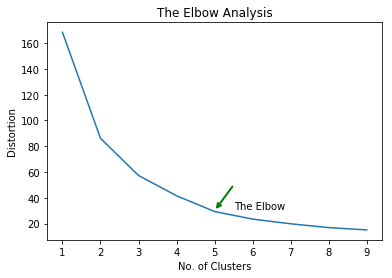

In [47]:
plt.plot(ks_distortions["Number of Clusters"], ks_distortions["Distortion"])
plt.title('The Elbow Analysis')
plt.xlabel('No. of Clusters')
plt.ylabel('Distortion')
plt.annotate('', xy=(5,30), xytext=(5.5,50), arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='green', lw=2))
#To annotate text 
plt.annotate('The Elbow', xy=(5.5,30), va='bottom', ha='left')
plt.show()

### Segmenting the Data into 5 clusters using k-means

In [48]:
kclusters=5
kmeans=KMeans(n_clusters=kclusters, random_state=21).fit(X_Norm)
print(kmeans.labels_)
print(kmeans.inertia_)

[3 0 0 0 0 4 4 0 0 0 4 0 1 0 0 1 0 0 4 0 0 0 2 0 0 4 4 4 3 0 0 0 3 4 0 4 0
 1 0 4 0 0 4 0 0 0 0 4 0 4 4 4 0 1 0 0 4 4 0 4 4 0 0 0 0 4 0 4 3 4 4 0 2 4
 4 1 0 0 3 0 0 4 0 0 0 0 0 1 0 0 1 0 3 4 0 1 0 0 4 1 1 1 4 3 0 0 4 0 4 3 0
 0 4 0 0 4 0 4 0 0 4 4 0 1 4 4 4 4 4 0 1 1 4 4 0 4 0 0 0 0]
29.378552099087436


### Adding Cluster labels to the original dataset with Crime and Venue data

In [49]:
Cluster_Crime_Venues=Crime_Venues.copy()
Cluster_Crime_Venues.insert(0,"Cluster Labels", kmeans.labels_)

### Plotting Clustered Neighbourhoods with population density as circle size

In [50]:
map_clusters=folium.Map(location=[Latitude, Longitude], zoom_start=11)
x=np.arange(kclusters)
ys=[i+x+(i*x)**2 for i in range(kclusters)]
colors_array=cm.rainbow(np.linspace(0,1,len(ys)))
rainbow=[colors.rgb2hex(i) for i in colors_array]
#add markers to the map
markers_colors=[]
for lat, lon, poi, cluster, density in zip(Cluster_Crime_Venues['Latitude'],
                                          Cluster_Crime_Venues['Longitude'],
                                          Cluster_Crime_Venues['Neighbourhood'],
                                          Cluster_Crime_Venues['Cluster Labels'],
                                          Cluster_Crime_Venues['Population_Density']):
    label=folium.Popup(str(poi)+'Cluster'+str(cluster), parse_html=True)
    folium.CircleMarker([lat,lon], radius=np.sqrt(density*10), popup=label, color=rainbow[int(cluster)],
                       fill=True, fill_color=rainbow[int(cluster-1)],
                       fill_opacity=0.7).add_to(map_clusters)
folium.map.Marker([(43.694286-.09),(-79.412848+.15)], icon=DivIcon(icon_size=(1000,100), icon_anchor=(0,0),
                                                                   html='<div style="font-size: 12pt">Circle Area = Population Density</div', 
                                                                  )).add_to(map_clusters)
map_clusters

### Plotting Clustered Neighbourhoods with Number of Parks as circle size

In [51]:
map_clusters=folium.Map(location=[Latitude, Longitude], zoom_start=11)
x=np.arange(kclusters)
ys=[i+x+(i*x)**2 for i in range(kclusters)]
colors_array=cm.rainbow(np.linspace(0,1,len(ys)))
rainbow=[colors.rgb2hex(i) for i in colors_array]
#add markers to the map
markers_colors=[]
for lat, lon, poi, cluster, parks in zip(Cluster_Crime_Venues['Latitude'],
                                          Cluster_Crime_Venues['Longitude'],
                                          Cluster_Crime_Venues['Neighbourhood'],
                                          Cluster_Crime_Venues['Cluster Labels'],
                                          Cluster_Crime_Venues['Park']):
    label=folium.Popup(str(poi)+'Cluster'+str(cluster), parse_html=True)
    folium.CircleMarker([lat,lon], radius=parks*2, popup=label, color=rainbow[int(cluster)],
                       fill=True, fill_color=rainbow[int(cluster-1)],
                       fill_opacity=0.7).add_to(map_clusters)
folium.map.Marker([(43.694286-.09),(-79.412848+.15)], icon=DivIcon(icon_size=(1000,100), icon_anchor=(0,0),
                                                                   html='<div style="font-size: 12pt">Circle Area = Number of Parks</div', 
                                                                  )).add_to(map_clusters)
map_clusters

### Obtaining and cleaning the data on average house prices in toronto fro the following website
https://www.moneysense.ca/spend/real-estate/where-to-buy-2019-toronto/

In [52]:
!wget -O moneysense.html https://www.moneysense.ca/spend/real-estate/where-to-buy-2019-toronto/  


--2020-02-13 10:02:00--  https://www.moneysense.ca/spend/real-estate/where-to-buy-2019-toronto/
Resolving www.moneysense.ca (www.moneysense.ca)... 104.26.1.154, 104.26.0.154, 2606:4700:20::681a:19a, ...
Connecting to www.moneysense.ca (www.moneysense.ca)|104.26.1.154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘moneysense.html’

    [ <=>                                   ] 173,049     --.-K/s   in 0.06s   

2020-02-13 10:02:01 (2.82 MB/s) - ‘moneysense.html’ saved [173049]



In [53]:
House_Prices_Raw=pd.read_html("moneysense.html")
House_Prices_Raw[0]

Rank                        Neighbourhood         Area  \
0       1                    Rockcliffe-Smythe  Toronto W03   
1       2                        Humber Summit  Toronto W05   
2       3               Glenfield-Jane Heights  Toronto W05   
3       4             Keelesdale-Eglinton West  Toronto W03   
4       5                      Little Portugal  Toronto C01   
5       6                      Oakwood-Vaughan  Toronto C03   
6       7                         Mount Dennis  Toronto W04   
7       8                 Kensington-Chinatown  Toronto C01   
8       9                             Oakridge  Toronto E06   
9      10                          Black Creek  Toronto W05   
10     11                            West Hill  Toronto E10   
11     12                   Caledonia-Fairbank  Toronto W03   
12     13                     Woodbine-Lumsden  Toronto E03   
13     14                 Briar Hill-Belgravia  Toronto W04   
14     15                       Dufferin Grove  Toronto C01   
15     16                               Weston  Toronto W04   
16     17                               Woburn  Toronto E09   
17     18    Mount Olive-Silverstone-Jamestown  Toronto W10   
18     19                           Humbermede  Toronto W05   
19     20                        Eglinton East  Toronto E08   
20     21                              Malvern  Toronto E11   
21     22                         Kennedy Park  Toronto E04   
22     23                      Rexdale-Kipling  Toronto W10   
23     24              Humberlea-Pelmo Park W4  Toronto W04   
24     25                     Elms-Old Rexdale  Toronto W10   
25     26                        Crescent Town  Toronto E03   
26     27                            Moss Park  Toronto C08   
27     28     Cabbagetown-South St. James Town  Toronto C08   
28     29               West Humber-Clairville  Toronto W10   
29     30                       South Parkdale  Toronto W01   
30     31                  Clairlea-Birchmount  Toronto E04   
31     32                               Mimico  Toronto W06   
32     33                            East York  Toronto E03   
33     34           Danforth Village-East York  Toronto E03   
34     35                            Rouge E10  Toronto E10   
35     36              Palmerston-Little Italy  Toronto C01   
36     37        Thistletown-Beaumonde Heights  Toronto W10   
37     38                   Weston-Pellam Park  Toronto W03   
38     39              Beechborough-Greenbrook  Toronto W04   
39     40                  Etobicoke West Mall  Toronto W08   
40     41                              Bendale  Toronto E09   
41     42                    Trinity-Bellwoods  Toronto C01   
42     43                              Ionview  Toronto E04   
43     44                          Regent Park  Toronto C08   
44     45                    Greenwood-Coxwell  Toronto E01   
45     46                          New Toronto  Toronto W06   
46     47                  Englemount-Lawrence  Toronto C04   
47     48                            Alderwood  Toronto W06   
48     49                          Blake-Jones  Toronto E01   
49     50                    O'Connor-Parkview  Toronto E03   
50     51                           Cliffcrest  Toronto E08   
51     52                Birchcliffe-Cliffside  Toronto E06   
52     53                          Morningside  Toronto E09   
53     54                   Yorkdale-Glen Park  Toronto W04   
54     55       Eringate-Centennial-West Deane  Toronto W08   
55     56                           University  Toronto C01   
56     57                       Bathurst Manor  Toronto C06   
57     58                               Rustic  Toronto W04   
58     59                    Woodbine Corridor  Toronto E02   
59     60           Islington-City Centre West  Toronto W08   
60     61                          Long Branch  Toronto W06   
61     62                   Humewood-Cedarvale  Toronto C03   
62     63        Kingsview Village-T

In [54]:
House_Prices=House_Prices_Raw[0].copy()
House_Prices.columns

Index(['Rank', 'Neighbourhood', 'Area', 'Average home price  (2017)', 'Value',
       'Momentum', 'Average price vs. area', 'Avg. price vs. metro  district',
       'Avg. price vs. outer region', '1-year price change',
       '5-year price change', 'Final Star Rating'],
      dtype='object')

In [55]:
House_Prices=House_Prices[['Neighbourhood','Average home price  (2017)']]
House_Prices.sort_values(by='Neighbourhood')[0:10]

Neighbourhood Average home price  (2017)
94                Agincourt North                   $873,976
118  Agincourt South-Malvern West                   $958,013
47                      Alderwood                   $873,114
63                          Annex                 $2,115,505
130             Banbury-Don Mills                 $1,199,256
56                 Bathurst Manor                   $933,915
79                Bayview Village                 $2,664,929
129         Bayview Woods-Steeles                 $1,199,256
71           Bedford Park-Nortown                   $908,743
38        Beechborough-Greenbrook                   $915,568

### Merging Average home prices dataset with the crime and venues dataset with cluster labels

In [56]:
Crime_Venues_Prices_Cluster=Cluster_Crime_Venues.merge(House_Prices, on='Neighbourhood', how='left')
print(Crime_Venues_Prices_Cluster.shape, Cluster_Crime_Venues.shape, House_Prices.shape)

(140, 347) (140, 346) (134, 2)


In [57]:
Crime_Venues_Prices_Cluster['Average home price  (2017)']=Crime_Venues_Prices_Cluster['Average home price  (2017)'].str.replace("$","")
Crime_Venues_Prices_Cluster['Average home price  (2017)']=Crime_Venues_Prices_Cluster['Average home price  (2017)'].str.replace(",","")
Crime_Venues_Prices_Cluster['Average home price  (2017)'].head()

0        NaN
1    2621947
2    1685373
3     940929
4     822992
Name: Average home price  (2017), dtype: object

In [58]:
Crime_Venues_Prices_Cluster.head()

Cluster Labels            Neighbourhood  Population  Size_of_hood_area  \
0               3           Yonge-St.Clair        3189       1.161315e+06   
1               0  York University Heights       36764       1.324666e+07   
2               0         Lansing-Westgate       10242       5.346186e+06   
3               0       Yorkdale-Glen Park       18233       6.038326e+06   
4               0      Stonegate-Queensway       22207       7.946202e+06   

    Latitude  Longitude  Assault_per_Capita  AutoTheft_per_Capita  \
0  43.688762 -79.399013            0.599812              0.678489   
1  43.759661 -79.499115            0.010211              0.001703   
2  43.753880 -79.422502            0.187805              0.020972   
3  43.717458 -79.452711            0.038200              0.008424   
4  43.636838 -79.496012            0.025956              0.008313   

   BreakandEnter_per_Capita  Robbery_per_Capita  Homicide_per_Capita  \
0                  0.226152            0.186830             0.000000   
1                  0.003846            0.001110             0.000073   
2                  0.049570            0.039084             0.000000   
3                  0.016843            0.010530             0.000603   
4                  0.008313            0.007300             0.000000   

   Population_Density  ATM  Accessories Store  Afghan Restaurant  \
0            2.746026    0                  0                  0   
1            2.775342    0                  0                  0   
2            1.915758    0                  0                  0   
3            3.019546    0                  1                  0   
4            2.794669    0                  0                  0   

   African Restaurant  Airport  Airport Lounge  American Restaurant  \
0                   0        0               0                    3   
1                   0        0               0                    0   
2                   0        0               0                    0   
3                   0        0               0                    2   
4                   0        0               0                    1   

   Amphitheater  Antique Shop  Aquarium  Arcade  Argentinian Restaurant  \
0             0             0         0       0                       0   
1             0             0         0       0                       0   
2             0             0         0       0                       0   
3             0             0         0       0                       0   
4             0             0         0       0                       0   

   Art Gallery  Arts & Crafts Store  Asian Restaurant  Athletics & Sports  \
0            0                    0                 0                   1   
1            0                    0                 0                   1   
2            0                    1                 0                   0   
3            0                    1                 0                   1   
4            0                    0                 0                   0   

   Auto Dealership  Automotive Shop  BBQ Joint  Baby Store  Badminton Court  \
0                0                0          2           0                0   
1                0                0          0           0                0   
2                0                0          0           0                0   
3                0                0          0           0                0   
4                0                0          1           0                0   

   Bagel Shop  Bakery  Bank  Bar  Baseball Field  Baseball Stadium  \
0           2       1     0    1               0                 0   
1           0       0     1    2               0                 0   
2           0       1     2    0               0                 0   
3           0       0     2    0               0                 0   
4           0       2     3    2               0                 0   

   Basketball Court  Basketball Stadium  Bath 

In [59]:
Crime_Venues_Prices_Cluster['Average home price  (2017)']=Crime_Venues_Prices_Cluster['Average home price  (2017)'].astype(float)

In [60]:
Crime_Venues_Prices_Cluster['Average home price  (2017)']=Crime_Venues_Prices_Cluster['Average home price  (2017)'].replace(np.nan, 
                                                           Crime_Venues_Prices_Cluster['Average home price  (2017)'].mean())
Crime_Venues_Prices_Cluster['Average home price  (2017)'].head()

0    1.275567e+06
1    2.621947e+06
2    1.685373e+06
3    9.409290e+05
4    8.229920e+05
Name: Average home price  (2017), dtype: float64

In [61]:
Crime_Venues_Prices_Cluster.head()

Cluster Labels            Neighbourhood  Population  Size_of_hood_area  \
0               3           Yonge-St.Clair        3189       1.161315e+06   
1               0  York University Heights       36764       1.324666e+07   
2               0         Lansing-Westgate       10242       5.346186e+06   
3               0       Yorkdale-Glen Park       18233       6.038326e+06   
4               0      Stonegate-Queensway       22207       7.946202e+06   

    Latitude  Longitude  Assault_per_Capita  AutoTheft_per_Capita  \
0  43.688762 -79.399013            0.599812              0.678489   
1  43.759661 -79.499115            0.010211              0.001703   
2  43.753880 -79.422502            0.187805              0.020972   
3  43.717458 -79.452711            0.038200              0.008424   
4  43.636838 -79.496012            0.025956              0.008313   

   BreakandEnter_per_Capita  Robbery_per_Capita  Homicide_per_Capita  \
0                  0.226152            0.186830             0.000000   
1                  0.003846            0.001110             0.000073   
2                  0.049570            0.039084             0.000000   
3                  0.016843            0.010530             0.000603   
4                  0.008313            0.007300             0.000000   

   Population_Density  ATM  Accessories Store  Afghan Restaurant  \
0            2.746026    0                  0                  0   
1            2.775342    0                  0                  0   
2            1.915758    0                  0                  0   
3            3.019546    0                  1                  0   
4            2.794669    0                  0                  0   

   African Restaurant  Airport  Airport Lounge  American Restaurant  \
0                   0        0               0                    3   
1                   0        0               0                    0   
2                   0        0               0                    0   
3                   0        0               0                    2   
4                   0        0               0                    1   

   Amphitheater  Antique Shop  Aquarium  Arcade  Argentinian Restaurant  \
0             0             0         0       0                       0   
1             0             0         0       0                       0   
2             0             0         0       0                       0   
3             0             0         0       0                       0   
4             0             0         0       0                       0   

   Art Gallery  Arts & Crafts Store  Asian Restaurant  Athletics & Sports  \
0            0                    0                 0                   1   
1            0                    0                 0                   1   
2            0                    1                 0                   0   
3            0                    1                 0                   1   
4            0                    0                 0                   0   

   Auto Dealership  Automotive Shop  BBQ Joint  Baby Store  Badminton Court  \
0                0                0          2           0                0   
1                0                0          0           0                0   
2                0                0          0           0                0   
3                0                0          0           0                0   
4                0                0          1           0                0   

   Bagel Shop  Bakery  Bank  Bar  Baseball Field  Baseball Stadium  \
0           2       1     0    1               0                 0   
1           0       0     1    2               0                 0   
2           0       1     2    0               0                 0   
3           0       0     2    0               0                 0   
4           0       2     3    2               0                 0   

   Basketball Court  Basketball Stadium  Bath 

### Plotting Average home prices as the size of circle of clustered neighbourhoods

In [62]:
map_clusters=folium.Map(location=[Latitude, Longitude], zoom_start=11)
x=np.arange(kclusters)
ys=[i+x+(i*x)**2 for i in range(kclusters)]
colors_array=cm.rainbow(np.linspace(0,1,len(ys)))
rainbow=[colors.rgb2hex(i) for i in colors_array]
#add markers to the map
markers_colors=[]
for lat, lon, poi, cluster, avg_home_price in zip(Crime_Venues_Prices_Cluster['Latitude'],
                                          Crime_Venues_Prices_Cluster['Longitude'],
                                          Crime_Venues_Prices_Cluster['Neighbourhood'],
                                          Crime_Venues_Prices_Cluster['Cluster Labels'],
                                          Crime_Venues_Prices_Cluster['Average home price  (2017)']):
    label=folium.Popup(str(poi)+'Cluster'+str(cluster)+"$"+str(avg_home_price), parse_html=True)
    folium.CircleMarker([lat,lon], radius=np.sqrt(avg_home_price/20000), popup=label, color=rainbow[int(cluster)],
                       fill=True, fill_color=rainbow[int(cluster-1)],
                       fill_opacity=0.7).add_to(map_clusters)
folium.map.Marker([(43.694286-.09),(-79.412848+.15)], icon=DivIcon(icon_size=(1000,100), icon_anchor=(0,0),
                                                                   html='<div style="font-size: 12pt">Circle Area = Average Home Price</div', 
                                                                  )).add_to(map_clusters)
map_clusters

### Bar graph of home price by clusters

In [63]:
Clusters_Price_Parks_Cafes_Yoga=pd.DataFrame(Crime_Venues_Prices_Cluster.groupby(
"Cluster Labels", as_index=False)[
    "Cluster Labels","Average home price  (2017)", "Park", "Coffee Shop", "Yoga Studio"].describe())

In [64]:
Clusters_Price_Parks_Cafes_Yoga

Cluster Labels                                     \
           count mean  std  min  25%  50%  75%  max   
0           72.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1           14.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0   
2            2.0  2.0  0.0  2.0  2.0  2.0  2.0  2.0   
3            8.0  3.0  0.0  3.0  3.0  3.0  3.0  3.0   
4           44.0  4.0  0.0  4.0  4.0  4.0  4.0  4.0   

  Average home price  (2017)                                             \
                       count          mean            std           min   
0                       72.0  1.280714e+06  612025.700570  6.311980e+05   
1                       14.0  1.159847e+06  345918.770453  7.002040e+05   
2                        2.0  1.275567e+06       0.000000  1.275567e+06   
3                        8.0  1.321765e+06  875366.495505  7.300110e+05   
4                       44.0  1.295567e+06  676592.232818  7.014480e+05   

                                                           Park            \
            25%           50%           75%           max count      mean   
0  9.093632e+05  1.199256e+06  1.342285e+06  3.757271e+06  72.0  2.236111   
1  8.745495e+05  1.231132e+06  1.425431e+06  1.773134e+06  14.0  3.571429   
2  1.275567e+06  1.275567e+06  1.275567e+06  1.275567e+06   2.0  2.500000   
3  7.965662e+05  9.424165e+05  1.415977e+06  3.287905e+06   8.0  2.125000   
4  9.158448e+05  1.177368e+06  1.323422e+06  4.755258e+06  44.0  2.545455   

                                       Coffee Shop                           \
        std  min   25%  50%   75%  max       count      mean       std  min   
0  1.578848  0.0  1.00  2.0  3.00  7.0        72.0  6.041667  2.913966  1.0   
1  2.027286  1.0  2.00  3.0  5.00  8.0        14.0  6.571429  2.793241  3.0   
2  0.707107  2.0  2.25  2.5  2.75  3.0         2.0  7.500000  4.949747  4.0   
3  2.167124  0.0  1.00  1.0  2.75  6.0         8.0  5.125000  1.642081  3.0   
4  1.823038  0.0  1.00  2.5  3.25  7.0        44.0  7.000000  2.332780  3.0   

                         Yoga Studio                                          \
    25%  50%   75%   max       count      mean       std  min  25%  50%  75%   
0  4.00  6.0  8.00  13.0        72.0  0.222222  0.632950  0.0  0.0  0.0  0.0   
1  5.25  6.0  7.00  13.0        14.0  0.928571  0.916875  0.0  0.0  1.0  1.0   
2  5.75  7.5  9.25  11.0         2.0  1.000000  0.000000  1.0  1.0  1.0  1.0   
3  4.00  5.0  5.50   8.0         8.0  0.500000  0.755929  0.0  0.0  0.0  1.0   
4  5.00  7.0  8.00  13.0        44.0  0.431818  0.695424  0.0  0.0  0.0  1.0   

        
   max  
0  3.0  
1  3.0  
2  1.0  
3  2.0  
4  3.0

In [65]:
Clusters_Price_Parks_Cafes_Yoga["Average home price  (2017)", "error"]=Clusters_Price_Parks_Cafes_Yoga[
    "Average home price  (2017)","std"]/np.sqrt(Clusters_Price_Parks_Cafes_Yoga["Average home price  (2017)","count"])
Clusters_Price_Parks_Cafes_Yoga["Park", "error"]=Clusters_Price_Parks_Cafes_Yoga[
    "Park","std"]/np.sqrt(Clusters_Price_Parks_Cafes_Yoga["Park","count"])
Clusters_Price_Parks_Cafes_Yoga["Coffee Shop", "error"]=Clusters_Price_Parks_Cafes_Yoga[
    "Coffee Shop","std"]/np.sqrt(Clusters_Price_Parks_Cafes_Yoga["Coffee Shop","count"])
Clusters_Price_Parks_Cafes_Yoga["Yoga Studio", "error"]=Clusters_Price_Parks_Cafes_Yoga[
    "Yoga Studio","std"]/np.sqrt(Clusters_Price_Parks_Cafes_Yoga["Yoga Studio","count"])
Clusters_Price_Parks_Cafes_Yoga

Cluster Labels                                     \
           count mean  std  min  25%  50%  75%  max   
0           72.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1           14.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0   
2            2.0  2.0  0.0  2.0  2.0  2.0  2.0  2.0   
3            8.0  3.0  0.0  3.0  3.0  3.0  3.0  3.0   
4           44.0  4.0  0.0  4.0  4.0  4.0  4.0  4.0   

  Average home price  (2017)                                             \
                       count          mean            std           min   
0                       72.0  1.280714e+06  612025.700570  6.311980e+05   
1                       14.0  1.159847e+06  345918.770453  7.002040e+05   
2                        2.0  1.275567e+06       0.000000  1.275567e+06   
3                        8.0  1.321765e+06  875366.495505  7.300110e+05   
4                       44.0  1.295567e+06  676592.232818  7.014480e+05   

                                                           Park            \
            25%           50%           75%           max count      mean   
0  9.093632e+05  1.199256e+06  1.342285e+06  3.757271e+06  72.0  2.236111   
1  8.745495e+05  1.231132e+06  1.425431e+06  1.773134e+06  14.0  3.571429   
2  1.275567e+06  1.275567e+06  1.275567e+06  1.275567e+06   2.0  2.500000   
3  7.965662e+05  9.424165e+05  1.415977e+06  3.287905e+06   8.0  2.125000   
4  9.158448e+05  1.177368e+06  1.323422e+06  4.755258e+06  44.0  2.545455   

                                       Coffee Shop                           \
        std  min   25%  50%   75%  max       count      mean       std  min   
0  1.578848  0.0  1.00  2.0  3.00  7.0        72.0  6.041667  2.913966  1.0   
1  2.027286  1.0  2.00  3.0  5.00  8.0        14.0  6.571429  2.793241  3.0   
2  0.707107  2.0  2.25  2.5  2.75  3.0         2.0  7.500000  4.949747  4.0   
3  2.167124  0.0  1.00  1.0  2.75  6.0         8.0  5.125000  1.642081  3.0   
4  1.823038  0.0  1.00  2.5  3.25  7.0        44.0  7.000000  2.332780  3.0   

                         Yoga Studio                                          \
    25%  50%   75%   max       count      mean       std  min  25%  50%  75%   
0  4.00  6.0  8.00  13.0        72.0  0.222222  0.632950  0.0  0.0  0.0  0.0   
1  5.25  6.0  7.00  13.0        14.0  0.928571  0.916875  0.0  0.0  1.0  1.0   
2  5.75  7.5  9.25  11.0         2.0  1.000000  0.000000  1.0  1.0  1.0  1.0   
3  4.00  5.0  5.50   8.0         8.0  0.500000  0.755929  0.0  0.0  0.0  1.0   
4  5.00  7.0  8.00  13.0        44.0  0.431818  0.695424  0.0  0.0  0.0  1.0   

       Average home price  (2017)      Park Coffee Shop Yoga Studio  
   max                      error     error       error       error  
0  3.0               72127.920522  0.186069    0.343414    0.074594  
1  3.0               92450.680192  0.541815    0.746525    0.245045  
2  1.0                   0.000000  0.500000    3.500000    0.000000  
3  2.0              309488.792498  0.766194    0.580563    0.267261  
4  3.0              102000.116924  0.274833    0.351680    0.104839

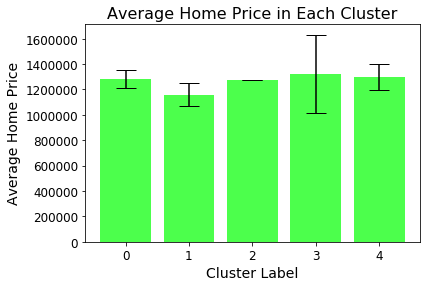

In [66]:
plt.bar(Clusters_Price_Parks_Cafes_Yoga.index, Clusters_Price_Parks_Cafes_Yoga["Average home price  (2017)","mean"],yerr= Clusters_Price_Parks_Cafes_Yoga
        ["Average home price  (2017)","error"],
        align='center', alpha=0.7,
       ecolor="black", capsize=10, color="lime")
plt.title("Average Home Price in Each Cluster", fontsize=16)
plt.ylabel("Average Home Price", fontsize=14)
plt.xlabel("Cluster Label", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

### Bar Graph of average number of parks, coffee shops, and yoga studios by cluster

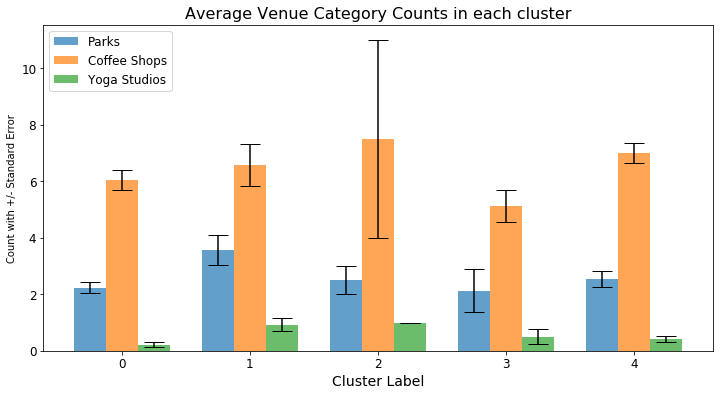

In [67]:
plt.figure(figsize=(12,6))
width=.25
plt.bar(Clusters_Price_Parks_Cafes_Yoga.index-width, Clusters_Price_Parks_Cafes_Yoga["Park","mean"],width, yerr= Clusters_Price_Parks_Cafes_Yoga
        ["Park","error"],
        align='center', alpha=0.7,
       ecolor="black", capsize=10, label="Parks")
plt.bar(Clusters_Price_Parks_Cafes_Yoga.index, Clusters_Price_Parks_Cafes_Yoga["Coffee Shop","mean"],width, yerr= Clusters_Price_Parks_Cafes_Yoga
        ["Coffee Shop","error"],
        align='center', alpha=0.7,
       ecolor="black", capsize=10, label="Coffee Shops")
plt.bar(Clusters_Price_Parks_Cafes_Yoga.index+width, Clusters_Price_Parks_Cafes_Yoga["Yoga Studio","mean"],width, yerr= Clusters_Price_Parks_Cafes_Yoga
        ["Yoga Studio","error"],
        align='center', alpha=0.7,
       ecolor="black", capsize=10, label="Yoga Studios")
plt.title("Average Venue Category Counts in each cluster", fontsize=16)
plt.xlabel("Cluster Label", fontsize=14)
plt.ylabel("Count with +/- Standard Error")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, loc="upper left")
plt.show()

### Creating a new dataframe and display the top 10 venues for each neighbourhood

In [68]:
def return_most_common_venues(row, num_top_venues):
    row_categories=row.iloc[1:]
    row_categories_sorted=row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [69]:
num_top_venues=10
indicators=['st','nd','rd']
columns=['Neighbourhood']
# Create columns according to the top venues
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
# Create a new dataframe
Top_Venues=pd.DataFrame(columns=columns)
Top_Venues['Neighbourhood']=Toronto_Grouped['Neighbourhood']
for ind in np.arange(Toronto_Grouped.shape[0]):
    Top_Venues.iloc[ind,1:]=return_most_common_venues(Toronto_Grouped.iloc[ind,:], num_top_venues)
Top_Venues.head()

Neighbourhood 1st Most Common Venue 2nd Most Common Venue  \
0               Agincourt North     Indian Restaurant    Chinese Restaurant   
1  Agincourt South-Malvern West    Chinese Restaurant        Clothing Store   
2                     Alderwood           Coffee Shop            Restaurant   
3                         Annex           Coffee Shop            Restaurant   
4             Banbury-Don Mills           Coffee Shop   Japanese Restaurant   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0           Coffee Shop        Sandwich Place                  Park   
1           Coffee Shop            Restaurant         Shopping Mall   
2      Department Store          Burger Joint  Fast Food Restaurant   
3    Italian Restaurant                  Park                   Spa   
4           Supermarket    Italian Restaurant          Burger Joint   

           6th Most Common Venue  7th Most Common Venue 8th Most Common Venue  \
0                  Shopping Mall  Vietnamese Restaurant           Pizza Place   
1                    Supermarket                   Bank      Sushi Restaurant   
2                 Clothing Store            Pizza Place                  Café   
3  Vegetarian / Vegan Restaurant    Japanese Restaurant     French Restaurant   
4                 Sandwich Place             Restaurant              Pharmacy   

  9th Most Common Venue  10th Most Common Venue  
0  Caribbean Restaurant                Pharmacy  
1   Sporting Goods Shop          Breakfast Spot  
2    Seafood Restaurant  Furniture / Home Store  
3                  Café                  Museum  
4      Asian Restaurant             Pizza Place

### Creating a new dataframe that includes the cluster as well as top 10 venues for each neighbourhood

In [70]:
#merging Toronto_Grouped with Toronto_Data to add latitude/longitude for each neighbourhood
Crime_Top_Venues_Prices_Cluster=Crime_Venues_Prices_Cluster.join(Top_Venues.set_index('Neighbourhood'), on='Neighbourhood').copy()
Crime_Top_Venues_Prices_Cluster.head()

Cluster Labels            Neighbourhood  Population  Size_of_hood_area  \
0               3           Yonge-St.Clair        3189       1.161315e+06   
1               0  York University Heights       36764       1.324666e+07   
2               0         Lansing-Westgate       10242       5.346186e+06   
3               0       Yorkdale-Glen Park       18233       6.038326e+06   
4               0      Stonegate-Queensway       22207       7.946202e+06   

    Latitude  Longitude  Assault_per_Capita  AutoTheft_per_Capita  \
0  43.688762 -79.399013            0.599812              0.678489   
1  43.759661 -79.499115            0.010211              0.001703   
2  43.753880 -79.422502            0.187805              0.020972   
3  43.717458 -79.452711            0.038200              0.008424   
4  43.636838 -79.496012            0.025956              0.008313   

   BreakandEnter_per_Capita  Robbery_per_Capita  Homicide_per_Capita  \
0                  0.226152            0.186830             0.000000   
1                  0.003846            0.001110             0.000073   
2                  0.049570            0.039084             0.000000   
3                  0.016843            0.010530             0.000603   
4                  0.008313            0.007300             0.000000   

   Population_Density  ATM  Accessories Store  Afghan Restaurant  \
0            2.746026    0                  0                  0   
1            2.775342    0                  0                  0   
2            1.915758    0                  0                  0   
3            3.019546    0                  1                  0   
4            2.794669    0                  0                  0   

   African Restaurant  Airport  Airport Lounge  American Restaurant  \
0                   0        0               0                    3   
1                   0        0               0                    0   
2                   0        0               0                    0   
3                   0        0               0                    2   
4                   0        0               0                    1   

   Amphitheater  Antique Shop  Aquarium  Arcade  Argentinian Restaurant  \
0             0             0         0       0                       0   
1             0             0         0       0                       0   
2             0             0         0       0                       0   
3             0             0         0       0                       0   
4             0             0         0       0                       0   

   Art Gallery  Arts & Crafts Store  Asian Restaurant  Athletics & Sports  \
0            0                    0                 0                   1   
1            0                    0                 0                   1   
2            0                    1                 0                   0   
3            0                    1                 0                   1   
4            0                    0                 0                   0   

   Auto Dealership  Automotive Shop  BBQ Joint  Baby Store  Badminton Court  \
0                0                0          2           0                0   
1                0                0          0           0                0   
2                0                0          0           0                0   
3                0                0          0           0                0   
4                0                0          1           0                0   

   Bagel Shop  Bakery  Bank  Bar  Baseball Field  Baseball Stadium  \
0           2       1     0    1               0                 0   
1           0       0     1    2               0                 0   
2           0       1     2    0               0                 0   
3           0       0     2    0               0                 0   
4           0       2     3    2               0                 0   

   Basketball Court  Basketball Stadium  Bath 

In [71]:
print(Crime_Top_Venues_Prices_Cluster.shape)
Crime_Top_Venues_Prices_Cluster.columns[0:20]

(140, 357)


Index(['Cluster Labels', 'Neighbourhood', 'Population', 'Size_of_hood_area',
       'Latitude', 'Longitude', 'Assault_per_Capita', 'AutoTheft_per_Capita',
       'BreakandEnter_per_Capita', 'Robbery_per_Capita', 'Homicide_per_Capita',
       'Population_Density', 'ATM', 'Accessories Store', 'Afghan Restaurant',
       'African Restaurant', 'Airport', 'Airport Lounge',
       'American Restaurant', 'Amphitheater'],
      dtype='object')

In [72]:
Crime_Top_Venues_Only_Prices_Cluster=Crime_Top_Venues_Prices_Cluster[['Cluster Labels', 'Neighbourhood', 'Population', 'Size_of_hood_area', 'Latitude','Longitude',
                                                                'Assault_per_Capita', 'AutoTheft_per_Capita', 'BreakandEnter_per_Capita','Robbery_per_Capita',
                                                                'Homicide_per_Capita', 'Population_Density', 'Average home price  (2017)',
                                                                '1st Most Common Venue','2nd Most Common Venue','3rd Most Common Venue',
                                                                '4th Most Common Venue','5th Most Common Venue','6th Most Common Venue','7th Most Common Venue',
                                                                      '8th Most Common Venue','9th Most Common Venue','10th Most Common Venue']].copy()
Crime_Top_Venues_Prices_Cluster.head()

Cluster Labels            Neighbourhood  Population  Size_of_hood_area  \
0               3           Yonge-St.Clair        3189       1.161315e+06   
1               0  York University Heights       36764       1.324666e+07   
2               0         Lansing-Westgate       10242       5.346186e+06   
3               0       Yorkdale-Glen Park       18233       6.038326e+06   
4               0      Stonegate-Queensway       22207       7.946202e+06   

    Latitude  Longitude  Assault_per_Capita  AutoTheft_per_Capita  \
0  43.688762 -79.399013            0.599812              0.678489   
1  43.759661 -79.499115            0.010211              0.001703   
2  43.753880 -79.422502            0.187805              0.020972   
3  43.717458 -79.452711            0.038200              0.008424   
4  43.636838 -79.496012            0.025956              0.008313   

   BreakandEnter_per_Capita  Robbery_per_Capita  Homicide_per_Capita  \
0                  0.226152            0.186830             0.000000   
1                  0.003846            0.001110             0.000073   
2                  0.049570            0.039084             0.000000   
3                  0.016843            0.010530             0.000603   
4                  0.008313            0.007300             0.000000   

   Population_Density  ATM  Accessories Store  Afghan Restaurant  \
0            2.746026    0                  0                  0   
1            2.775342    0                  0                  0   
2            1.915758    0                  0                  0   
3            3.019546    0                  1                  0   
4            2.794669    0                  0                  0   

   African Restaurant  Airport  Airport Lounge  American Restaurant  \
0                   0        0               0                    3   
1                   0        0               0                    0   
2                   0        0               0                    0   
3                   0        0               0                    2   
4                   0        0               0                    1   

   Amphitheater  Antique Shop  Aquarium  Arcade  Argentinian Restaurant  \
0             0             0         0       0                       0   
1             0             0         0       0                       0   
2             0             0         0       0                       0   
3             0             0         0       0                       0   
4             0             0         0       0                       0   

   Art Gallery  Arts & Crafts Store  Asian Restaurant  Athletics & Sports  \
0            0                    0                 0                   1   
1            0                    0                 0                   1   
2            0                    1                 0                   0   
3            0                    1                 0                   1   
4            0                    0                 0                   0   

   Auto Dealership  Automotive Shop  BBQ Joint  Baby Store  Badminton Court  \
0                0                0          2           0                0   
1                0                0          0           0                0   
2                0                0          0           0                0   
3                0                0          0           0                0   
4                0                0          1           0                0   

   Bagel Shop  Bakery  Bank  Bar  Baseball Field  Baseball Stadium  \
0           2       1     0    1               0                 0   
1           0       0     1    2               0                 0   
2           0       1     2    0               0                 0   
3           0       0     2    0               0                 0   
4           0       2     3    2               0                 0   

   Basketball Court  Basketball Stadium  Bath 

### Calculating the average normalized crime rate to represent all 5 crime types

In [73]:
Crime_Top_Venues_Only_Prices_Cluster["Average Crime"]=(Crime_Top_Venues_Prices_Cluster['Assault_per_Capita']/Crime_Top_Venues_Prices_Cluster['Assault_per_Capita'].max()+
    Crime_Top_Venues_Prices_Cluster['AutoTheft_per_Capita']/Crime_Top_Venues_Prices_Cluster['AutoTheft_per_Capita'].max()+
    Crime_Top_Venues_Prices_Cluster['BreakandEnter_per_Capita']/Crime_Top_Venues_Prices_Cluster['BreakandEnter_per_Capita'].max()+
    Crime_Top_Venues_Prices_Cluster['Robbery_per_Capita']/Crime_Top_Venues_Prices_Cluster['Robbery_per_Capita'].max()+
    Crime_Top_Venues_Prices_Cluster['Homicide_per_Capita']/Crime_Top_Venues_Prices_Cluster['Homicide_per_Capita'].max())/5
Crime_Top_Venues_Only_Prices_Cluster["Average Crime"].head()

0    0.549851
1    0.006276
2    0.091709
3    0.040392
4    0.016525
Name: Average Crime, dtype: float64

In [74]:
Crime_Top_Venues_Only_Prices_Cluster["Average_Crime"]=Crime_Top_Venues_Only_Prices_Cluster["Average Crime"]*100
Crime_Top_Venues_Only_Prices_Cluster["Average Crime"].head()

0    0.549851
1    0.006276
2    0.091709
3    0.040392
4    0.016525
Name: Average Crime, dtype: float64

### Plotting average normalized crime rate as the circle size representing clustered neighbourhoods

In [75]:
map_clusters=folium.Map(location=[Latitude, Longitude], zoom_start=11)
x=np.arange(kclusters)
ys=[i+x+(i*x)**2 for i in range(kclusters)]
colors_array=cm.rainbow(np.linspace(0,1,len(ys)))
rainbow=[colors.rgb2hex(i) for i in colors_array]
#add markers to the map
markers_colors=[]
for lat, lon, poi, cluster, avg_crime in zip(Crime_Venues_Prices_Cluster['Latitude'],
                                          Crime_Venues_Prices_Cluster['Longitude'],
                                          Crime_Venues_Prices_Cluster['Neighbourhood'],
                                          Crime_Venues_Prices_Cluster['Cluster Labels'],
                                          Crime_Top_Venues_Only_Prices_Cluster['Average Crime']):
    label=folium.Popup(str(poi)+'Cluster'+str(cluster), parse_html=True)
    folium.CircleMarker([lat,lon], radius=np.sqrt(avg_crime*500), popup=label, color=rainbow[int(cluster)],
                       fill=True, fill_color=rainbow[int(cluster-1)],
                       fill_opacity=0.7).add_to(map_clusters)
folium.map.Marker([(43.694286-.09),(-79.412848+.15)], icon=DivIcon(icon_size=(1000,100), icon_anchor=(0,0),
                                                                   html='<div style="font-size: 12pt">Circle Area = Crime Rate(Normalized)</div', 
                                                                  )).add_to(map_clusters)
map_clusters

### Drop the 5 crime rate features to create a more concise summary of the neighbourhoods

In [76]:
Crime_Top_Venues_Only_Prices_Cluster.drop(['Assault_per_Capita', 'AutoTheft_per_Capita','BreakandEnter_per_Capita', 'Robbery_per_Capita', 'Homicide_per_Capita']
                                         , axis=1, inplace=True)
Crime_Top_Venues_Only_Prices_Cluster

Cluster Labels                        Neighbourhood  Population  \
0                 3                       Yonge-St.Clair        3189   
1                 0              York University Heights       36764   
2                 0                     Lansing-Westgate       10242   
3                 0                   Yorkdale-Glen Park       18233   
4                 0                  Stonegate-Queensway       22207   
5                 4               Tam O'Shanter-Sullivan       43695   
6                 4                          The Beaches       28378   
7                 0         Thistletown-Beaumond Heights       16039   
8                 0                     Thorncliffe Park        8352   
9                 0                   Danforth East York       10485   
10                4                   Humewood-Cedarvale       11124   
11                0           Islington-City Centre West       56701   
12                1                             Danforth       16749   
13                0                               Rustic        7525   
14                0                  Scarborough Village       14566   
15                1                       South Parkdale       34420   
16                0                      South Riverdale       32071   
17                0                 St.Andrew-Windfields       19066   
18                4                        Taylor-Massey        9584   
19                0                        Humber Summit       14188   
20                0                           Humbermede        6029   
21                0               Centennial Scarborough       10932   
22                2                Church-Yonge Corridor       36499   
23                0                  Clairlea-Birchmount       34751   
24                0                           Cliffcrest       19890   
25                4                      Flemingdon Park       23841   
26                4               Corso Italia-Davenport       11380   
27                4                              Ionview       10925   
28                3                        Junction Area        4755   
29                0                      Broadview North        7449   
30                0                   Princess-Rosethorn        8588   
31                0                      North Riverdale        9173   
32                3                  Etobicoke West Mall        4354   
33                4                    Forest Hill North       11459   
34                0               Glenfield-Jane Heights       26132   
35                4                    Greenwood-Coxwell       14261   
36                0                            Guildwood       14842   
37                1                    Trinity-Bellwoods       24358   
38                0                     Victoria Village       11725   
39                4    Waterfront Communities-The Island       84915   
40                0                            West Hill       36371   
41                0               West Humber-Clairville       36570   
42                4                  Westminster-Branson       27822   
43                0                         Kennedy Park       18203   
44                0        Kingsview Village-The Westway       14306   
45                0                Bayview Woods-Steeles        8350   
46                0                         Clanton Park       20575   
47                4             Keelesdale-Eglinton West        9357   
48                0                    O'Connor-Parkview       23514   
49                4                        Old East York       16619   
50                4                            Casa Loma       15595   
51                4                 Kensington-Chinatown       13415   
52                0                       Kingsway South        5175   
53                1         Runnymede-Bloor West Village       17358   
54                0                    Forest

### Exploring Clusters

In [77]:
table_df=pd.DataFrame(Crime_Top_Venues_Only_Prices_Cluster.groupby('Cluster Labels', as_index=False)["Neighbourhood"].count())
table_df.rename(columns={"Neighbourhood":"No. of Neighbourhoods"})

Cluster Labels  No. of Neighbourhoods
0               0                     72
1               1                     14
2               2                      2
3               3                      8
4               4                     44

In [78]:
Crime_Top_Venues_Only_Prices_Cluster.loc[Crime_Top_Venues_Only_Prices_Cluster["Cluster Labels"]==0, Crime_Top_Venues_Only_Prices_Cluster.columns[[1]+
                                        list(range(5, Crime_Top_Venues_Only_Prices_Cluster.shape[1]))]]["1st Most Common Venue"].value_counts()[0:10]

Coffee Shop             40
Fast Food Restaurant     5
Park                     5
Pizza Place              4
Chinese Restaurant       3
Sandwich Place           3
Café                     2
Clothing Store           2
Indian Restaurant        2
Korean Restaurant        2
Name: 1st Most Common Venue, dtype: int64

In [79]:
Crime_Top_Venues_Only_Prices_Cluster.loc[Crime_Top_Venues_Only_Prices_Cluster["Cluster Labels"]==1, Crime_Top_Venues_Only_Prices_Cluster.columns[[1]+
                                        list(range(5, Crime_Top_Venues_Only_Prices_Cluster.shape[1]))]]["1st Most Common Venue"].value_counts()[0:10]

Café                  5
Bar                   2
Italian Restaurant    2
Coffee Shop           2
Korean Restaurant     1
Park                  1
Bakery                1
Name: 1st Most Common Venue, dtype: int64

In [80]:
Crime_Top_Venues_Only_Prices_Cluster.loc[Crime_Top_Venues_Only_Prices_Cluster["Cluster Labels"]==2, Crime_Top_Venues_Only_Prices_Cluster.columns[[1]+
                                        list(range(5, Crime_Top_Venues_Only_Prices_Cluster.shape[1]))]]["1st Most Common Venue"].value_counts()[0:10]

Japanese Restaurant    1
Coffee Shop            1
Name: 1st Most Common Venue, dtype: int64

In [81]:
Crime_Top_Venues_Only_Prices_Cluster.loc[Crime_Top_Venues_Only_Prices_Cluster["Cluster Labels"]==3, Crime_Top_Venues_Only_Prices_Cluster.columns[[1]+
                                        list(range(5, Crime_Top_Venues_Only_Prices_Cluster.shape[1]))]]["1st Most Common Venue"].value_counts()[0:10]

Coffee Shop           4
Café                  2
Sandwich Place        1
Italian Restaurant    1
Name: 1st Most Common Venue, dtype: int64

In [82]:
Crime_Top_Venues_Only_Prices_Cluster.loc[Crime_Top_Venues_Only_Prices_Cluster["Cluster Labels"]==4, Crime_Top_Venues_Only_Prices_Cluster.columns[[1]+
                                        list(range(5, Crime_Top_Venues_Only_Prices_Cluster.shape[1]))]]["1st Most Common Venue"].value_counts()[0:10]

Coffee Shop             21
Café                     9
Italian Restaurant       4
Fast Food Restaurant     2
Park                     2
Chinese Restaurant       1
Pizza Place              1
Clothing Store           1
Sandwich Place           1
Gym                      1
Name: 1st Most Common Venue, dtype: int64

### Exploring average Crime Rate and Population Density

In [83]:
Popup_Crime_Clusters=pd.DataFrame(Crime_Top_Venues_Only_Prices_Cluster.groupby("Cluster Labels", as_index=False)["Cluster Labels", "Population_Density", 
                                                                                                          "Average_Crime"].describe())
Popup_Crime_Clusters

Cluster Labels                                    Population_Density  \
           count mean  std  min  25%  50%  75%  max              count   
0           72.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0               72.0   
1           14.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0               14.0   
2            2.0  2.0  0.0  2.0  2.0  2.0  2.0  2.0                2.0   
3            8.0  3.0  0.0  3.0  3.0  3.0  3.0  3.0                8.0   
4           44.0  4.0  0.0  4.0  4.0  4.0  4.0  4.0               44.0   

                                                                               \
        mean       std        min        25%        50%        75%        max   
0   3.391332  1.244026   0.839511   2.444675   3.545877   4.471487   5.184260   
1  13.359148  2.395544  10.846162  11.473040  12.708295  14.739712  18.633067   
2  29.301789  3.611492  26.748078  28.024933  29.301789  30.578644  31.855499   
3   2.543100  1.486470   1.199872   1.699717   2.270945   2.740525   5.932899   
4   7.158123  1.354413   5.311935   6.014834   7.094507   8.059822  10.047043   

  Average_Crime                                                         \
          count       mean        std        min        25%        50%   
0          72.0   4.961064   5.126135   0.108411   0.917648   3.498047   
1          14.0   2.237054   2.189540   0.195973   0.512407   0.993215   
2           2.0   3.667911   4.020183   0.825212   2.246561   3.667911   
3           8.0  45.230260  11.164344  32.569354  37.787816  40.974270   
4          44.0   4.165014   5.267625   0.143958   0.898458   2.468118   

                         
         75%        max  
0   8.062445  20.472058  
1   3.847066   7.306593  
2   5.089260   6.510610  
3  55.533469  61.917481  
4   4.296778  24.956458

In [84]:
Popup_Crime_Clusters["Population_Density", "error"]=Popup_Crime_Clusters["Population_Density","std"]/np.sqrt(Popup_Crime_Clusters["Population_Density", "count"])
Popup_Crime_Clusters["Average_Crime", "error"]=Popup_Crime_Clusters["Average_Crime","std"]/np.sqrt(Popup_Crime_Clusters["Average_Crime", "count"])
Popup_Crime_Clusters

Cluster Labels                                    Population_Density  \
           count mean  std  min  25%  50%  75%  max              count   
0           72.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0               72.0   
1           14.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0               14.0   
2            2.0  2.0  0.0  2.0  2.0  2.0  2.0  2.0                2.0   
3            8.0  3.0  0.0  3.0  3.0  3.0  3.0  3.0                8.0   
4           44.0  4.0  0.0  4.0  4.0  4.0  4.0  4.0               44.0   

                                                                               \
        mean       std        min        25%        50%        75%        max   
0   3.391332  1.244026   0.839511   2.444675   3.545877   4.471487   5.184260   
1  13.359148  2.395544  10.846162  11.473040  12.708295  14.739712  18.633067   
2  29.301789  3.611492  26.748078  28.024933  29.301789  30.578644  31.855499   
3   2.543100  1.486470   1.199872   1.699717   2.270945   2.740525   5.932899   
4   7.158123  1.354413   5.311935   6.014834   7.094507   8.059822  10.047043   

  Average_Crime                                                         \
          count       mean        std        min        25%        50%   
0          72.0   4.961064   5.126135   0.108411   0.917648   3.498047   
1          14.0   2.237054   2.189540   0.195973   0.512407   0.993215   
2           2.0   3.667911   4.020183   0.825212   2.246561   3.667911   
3           8.0  45.230260  11.164344  32.569354  37.787816  40.974270   
4          44.0   4.165014   5.267625   0.143958   0.898458   2.468118   

                        Population_Density Average_Crime  
         75%        max              error         error  
0   8.062445  20.472058           0.146610      0.604121  
1   3.847066   7.306593           0.640236      0.585179  
2   5.089260   6.510610           2.553710      2.842699  
3  55.533469  61.917481           0.525547      3.947192  
4   4.296778  24.956458           0.204185      0.794124

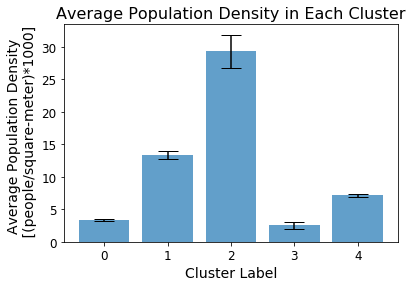

In [85]:
plt.bar(Popup_Crime_Clusters.index, Popup_Crime_Clusters["Population_Density", "mean"], yerr=Popup_Crime_Clusters["Population_Density","error"], align="center",
        alpha=0.7, ecolor='black', capsize=10)
plt.title("Average Population Density in Each Cluster", fontsize=16)
plt.xlabel("Cluster Label", fontsize=14)
plt.ylabel("Average Population Density \n [(people/square-meter)*1000]", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

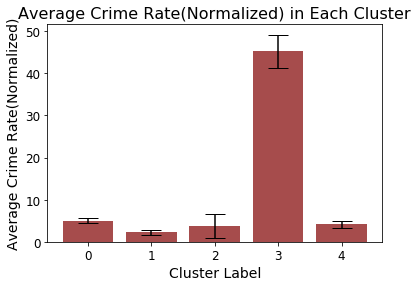

In [86]:
plt.bar(Popup_Crime_Clusters.index, Popup_Crime_Clusters["Average_Crime", "mean"], yerr=Popup_Crime_Clusters["Average_Crime","error"], align="center",
        alpha=0.7, ecolor='black', capsize=10, color='Maroon')
plt.title("Average Crime Rate(Normalized) in Each Cluster", fontsize=16)
plt.xlabel("Cluster Label", fontsize=14)
plt.ylabel("Average Crime Rate(Normalized)", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

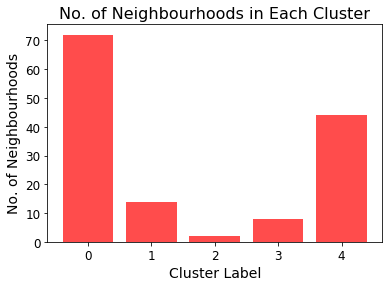

In [87]:
plt.bar(Popup_Crime_Clusters.index, Popup_Crime_Clusters["Average_Crime", "count"], align="center",
        alpha=0.7, ecolor='black', capsize=10, color='Red')
plt.title("No. of Neighbourhoods in Each Cluster", fontsize=16)
plt.xlabel("Cluster Label", fontsize=14)
plt.ylabel("No. of Neighbourhoods", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

### Exploring Cluster "0",  Filtering out the neighbourhoods that have the average home price greater than CAD 800,000 and crime rate greater than 4

In [88]:
Crime_Top_Venues_Prices_Cluster[Crime_Top_Venues_Prices_Cluster["Neighbourhood"]=="Forest Hill South"]["Average home price  (2017)"]

54    1319395.0
Name: Average home price  (2017), dtype: float64

In [89]:
Crime_Top_Venues_Prices_Cluster[Crime_Top_Venues_Prices_Cluster["Neighbourhood"]=="Forest Hill South"]["Population_Density"]

54    5.014873
Name: Population_Density, dtype: float64

In [90]:
Neighbourhood_Best_Fit=Crime_Top_Venues_Only_Prices_Cluster[(Crime_Top_Venues_Prices_Cluster['Cluster Labels']==0)& 
                                                            (Crime_Top_Venues_Prices_Cluster['Average home price  (2017)']<800000.0)].drop([
"Size_of_hood_area","6th Most Common Venue", "7th Most Common Venue","8th Most Common Venue","9th Most Common Venue","10th Most Common Venue"], axis=1)

Neighbourhood_Best_Fit.columns

Index(['Cluster Labels', 'Neighbourhood', 'Population', 'Latitude',
       'Longitude', 'Population_Density', 'Average home price  (2017)',
       '1st Most Common Venue', '2nd Most Common Venue',
       '3rd Most Common Venue', '4th Most Common Venue',
       '5th Most Common Venue', 'Average Crime', 'Average_Crime'],
      dtype='object')

In [91]:
Neighbourhood_Best_Fit=Neighbourhood_Best_Fit[['Neighbourhood','Population_Density','Average_Crime','Average home price  (2017)','1st Most Common Venue',
                                              '2nd Most Common Venue','3rd Most Common Venue','4th Most Common Venue','5th Most Common Venue',
                                              'Latitude','Longitude']]
Neighbourhood_Best_Fit

Neighbourhood  Population_Density  Average_Crime  \
19            Humber Summit            1.780867       2.251131   
20               Humbermede            1.363514       7.374925   
34   Glenfield-Jane Heights            5.074424       1.547167   
43             Kennedy Park            5.083607       6.414137   
77            Eglinton East            1.956474       9.094528   
83               L'Amoreaux            4.154920       0.529240   
89    Birchcliffe-Cliffside            4.332918       0.846891   
94              Black Creek            4.991857      20.217846   
111                  Woburn            2.830533       0.206713   
118                  Weston            4.452868       4.539476   
122                 Malvern            4.042411       0.872694   

     Average home price  (2017) 1st Most Common Venue 2nd Most Common Venue  \
19                     706722.0                  Bank                  Park   
20                     772315.0           Coffee Shop     Indian Restaurant   
34                     745701.0           Coffee Shop           Pizza Place   
43                     729499.0           Coffee Shop  Fast Food Restaurant   
77                     631198.0  Fast Food Restaurant              Pharmacy   
83                     784794.0  Fast Food Restaurant           Coffee Shop   
89                     725980.0           Coffee Shop                   Pub   
94                     730270.0           Coffee Shop  Fast Food Restaurant   
111                    746787.0           Coffee Shop  Fast Food Restaurant   
118                    729035.0           Pizza Place        Sandwich Place   
122                    692097.0  Fast Food Restaurant           Pizza Place   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
19       Asian Restaurant           Coffee Shop    Mexican Restaurant   
20            Pizza Place  Caribbean Restaurant  Fast Food Restaurant   
34          Grocery Store                  Park           Gas Station   
43          Grocery Store              Pharmacy        Discount Store   
77            Pizza Place        Sandwich Place           Coffee Shop   
83     Chinese Restaurant              Pharmacy           Pizza Place   
89                  Diner   Filipino Restaurant          Burger Joint   
94            Gas Station           Pizza Place                 Hotel   
111           Pizza Place    Chinese Restaurant           Gas Station   
118           Coffee Shop           Gas Station  Fast Food Restaurant   
122              Pharmacy        Sandwich Place           Coffee Shop   

      Latitude  Longitude  
19   43.756657 -79.570138  
20   43.741473 -79.551884  
34   43.745591 -79.505161  
43   43.726791 -79.260034  
77   43.743029 -79.245636  
83   43.791460 -79.309635  
89   43.688760 -79.262795  
94   43.765908 -79.513970  
111  43.765936 -79.223175  
118  43.703800 -79.522170  
122  43.803431 -79.222301

In [92]:
# Creating a map for toronto using latitude and longitude
Toronto_Hood_Map=folium.Map(location=[Latitude, Longitude], zoom_start=11)
#adding markers to the map
for lat, lon, neighbourhood, crime in zip(Neighbourhood_Best_Fit['Latitude'], Neighbourhood_Best_Fit['Longitude'], 
                                              Neighbourhood_Best_Fit['Neighbourhood'],Neighbourhood_Best_Fit['Average_Crime']):
    label='{}'.format(neighbourhood)
    label=folium.Popup(parse_html=True)
    folium.CircleMarker([lat,lon], radius=np.sqrt(crime*50),
                       popup=label, color='red', fill=True, fill_color='white', fill_opacity=0.7,
                       parse_html=False).add_to(Toronto_Hood_Map)
folium.map.Marker([(43.694286-.09), (-79.412848+.08)], icon = DivIcon(icon_size=(1000,100), icon_anchor=(0,0), 
                   html='<div style="font_size: 12pt">Circle Area = Normalized Crime Rate with Home price less than $800,000  </div>',
                                                                   )
                 ).add_to(Toronto_Hood_Map)
Toronto_Hood_Map


In [93]:
Neighbourhood_Best_Fit=Neighbourhood_Best_Fit[Neighbourhood_Best_Fit["Average_Crime"]<4]
Neighbourhood_Best_Fit

Neighbourhood  Population_Density  Average_Crime  \
19            Humber Summit            1.780867       2.251131   
34   Glenfield-Jane Heights            5.074424       1.547167   
83               L'Amoreaux            4.154920       0.529240   
89    Birchcliffe-Cliffside            4.332918       0.846891   
111                  Woburn            2.830533       0.206713   
122                 Malvern            4.042411       0.872694   

     Average home price  (2017) 1st Most Common Venue 2nd Most Common Venue  \
19                     706722.0                  Bank                  Park   
34                     745701.0           Coffee Shop           Pizza Place   
83                     784794.0  Fast Food Restaurant           Coffee Shop   
89                     725980.0           Coffee Shop                   Pub   
111                    746787.0           Coffee Shop  Fast Food Restaurant   
122                    692097.0  Fast Food Restaurant           Pizza Place   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
19       Asian Restaurant           Coffee Shop    Mexican Restaurant   
34          Grocery Store                  Park           Gas Station   
83     Chinese Restaurant              Pharmacy           Pizza Place   
89                  Diner   Filipino Restaurant          Burger Joint   
111           Pizza Place    Chinese Restaurant           Gas Station   
122              Pharmacy        Sandwich Place           Coffee Shop   

      Latitude  Longitude  
19   43.756657 -79.570138  
34   43.745591 -79.505161  
83   43.791460 -79.309635  
89   43.688760 -79.262795  
111  43.765936 -79.223175  
122  43.803431 -79.222301

### Plotting the best Neighbourhoods 

In [94]:
# Creating a map for toronto using latitude and longitude
Toronto_Hood_Map=folium.Map(location=[Latitude, Longitude], zoom_start=11)
#adding markers to the map
for lat, lon, neighbourhood, crime in zip(Neighbourhood_Best_Fit['Latitude'], Neighbourhood_Best_Fit['Longitude'], 
                                              Neighbourhood_Best_Fit['Neighbourhood'],Neighbourhood_Best_Fit['Average_Crime']):
    label='{}'.format(neighbourhood)
    label=folium.Popup(parse_html=True)
    folium.CircleMarker([lat,lon], radius=np.sqrt(crime*50),
                       popup=label, color='red', fill=True, fill_color='white', fill_opacity=0.7,
                       parse_html=False).add_to(Toronto_Hood_Map)
folium.map.Marker([(43.694286-.09), (-79.412848+.08)], icon = DivIcon(icon_size=(1000,100), icon_anchor=(0,0), 
                   html='<div style="font_size: 12pt">Circle Area = Normalized Crime Rate less than 4 </div>',
                                                                   )
                 ).add_to(Toronto_Hood_Map)
Toronto_Hood_Map


In [95]:
Neighbourhood_Best_Fit["Neighbourhood"]

19              Humber Summit
34     Glenfield-Jane Heights
83                 L'Amoreaux
89      Birchcliffe-Cliffside
111                    Woburn
122                   Malvern
Name: Neighbourhood, dtype: object

## Results and Discussion <a name="results"></a>

In this case study, the data about crime, population density, access to different venues were considered in order to segment the neighbourhoods similar to that of Forest Hill South, but more affordable. Since Forest Hill has low crime rates, medium population density and reasonable access to coffee shops, they were chosen. The only problem was the average price range exceeded the budget. So we needed to find neighbourhoods comparable to Forest Hill South but with house prices less than 800,000 CAD. K-Means clustering was used to segment the data, and the number of clusters k was found using the elbow test. Here the appropriate value of k was found to be 5.

Even though the neighbourhoods were not evenly distributed among the clusters, it seemed to be representative of data, with respect to crime rates and population density as the averages of those two features were different between clusters with small standard error. However, with venue category features, it wasn’t the case although small differences between clusters were observed. This was to be expected as there were over 300 venue features and a small weight (1/(number of venue category features)) was assigned to each of them individually relative to the weight of crime rate and population density. In a future analysis, we could further categorize venue types, hence reducing the number of features and improving their weights as a result.

The Cluster that contained Forest Hill South has 72 members. However, only 6 neighbourhoods fulfilled the criteria of crime rate less than 4 and average price lower than 800,000 CAD. The neighbourhoods which satisfied the requirements are as follows: Humber Summit, Glenfield-Jane Heights, L’Amoreaux, Birchcliffe-Cliffside, Woburn, and Malvern.


## Conclusion <a name="conclusion"></a>


In this case study, 6 neighbourhoods were identified in Toronto with similarity to Forest Hill South but with an average price less than 800,000 CAD. This analysis will help the customer in their search to find a new home. This analysis also can be used by other customers to find neighbourhoods similar to their favourite neighbourhood, in terms of population density, low crime rate and access to venues.


## *Thank You!*